In [4]:
##### nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build

# !pip install snowflake --user
# !pip install snowflake-connector-python --userqr4
# !pip install category_encoders
# !pip install xgboost
# !pip install fuzzywuzzy --user
# !pip install lightgbm --user


import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

pd.options.mode.chained_assignment = None

You have an incompatible version of 'pyarrow' installed (6.0.0), please install a version that adheres to: 'pyarrow<5.1.0,>=5.0.0; extra == "pandas"'
Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


## Functions

In [1]:
def get_agg_first_views(df_in, grpby_title, agg_col, first_view_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()

    return df_in

def get_plot(dflist, varlist, labellist=None,  ## Old
              title=None, config={}, x_var='order_date', y_var='y_var',  mode='lines+markers'):
    ## Create dataframe x var combinations (plot all variables for each dataframe)
    dfvarlist=itertools.product(*[dflist,varlist])
        
    ## For every dataframe x variable, create a data trace for plotting
    data=[]    
    for dfvar, name in zip(dfvarlist, labellist):
        dfplt,var=dfvar[0], dfvar[1]
        data = data + [go.Scatter(x=dfplt[x_var], y=dfplt[var], mode=mode, name=name)]  

    ## Initiate offline plot and create plot
    py.offline.init_notebook_mode(connected=True) 
    layout = dict(title = title,
                  xaxis = dict(title = x_var), #, range=['2017-09-01','2017-02-01']
                  yaxis = dict(title = y_var),
                  autosize=False,
                  width=(600),
                  height=(400),
                  showlegend=True,
                 )
    fig = dict(data=data, layout=layout)
    return fig

def evaluate_pred_group(df_plt, grpby, key, pred_list):

    for quarter, group in df_plt.groupby(grpby):
        actuals_mean=group['first_views'].mean()
        actuals_sum=group['first_views'].sum()
        print('_____________________________________________________________')
        print(f'{key} {quarter} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
        for i in ['median_mx'] + list_postfix:  
            mae = MAE(group['first_views'], group[f'first_views_decay_{i}'])
            pred= group[f'first_views_decay_{i}'].sum()
            print(f'{key} {quarter} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')
    
    return

def evaluate_pred_plt(df_plt, grpby, var_list):
    mean_var_list = [f'mae_{i}' for i in var_list]
    sum_var_list = ['first_views'] + var_list 
    mean_dic = dict(zip(mean_var_list, ['mean'] * len(mean_var_list)))
    sum_dic = dict(zip(sum_var_list, ['sum'] * len(sum_var_list)))
    
    # Get absolute error at agg_time- title level
    df_grp = df_plt.groupby(by=grpby).agg(sum_dic).reset_index()
    for i in var_list:
        df_grp[f'mae_{i}'] = (df_grp[i] - df_grp['first_views']).abs()  ## mae is actually ae here. mean taken in the next step

    ## aggregate to agg_time level (month, quarter)
    agg_dic =  {k: v for d in (mean_dic, sum_dic) for k, v in d.items()}
    df_grp = df_grp.groupby(by=grpby[:-2]).agg(agg_dic).reset_index()
    for i in var_list:
        df_grp[f'pct_error_{i}'] = (df_grp[i] - df_grp['first_views'])/df_grp['first_views']*100

    return df_grp

def get_pred_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'first_views_decay_{i}' for i in ['median_mx', 'dev_b']] + ['first_views'] ## Variables to be plotted
            ,'title': title  ## Plot title
            ,'labellist':['RW mean','XGB', 'Actual'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': 'First views'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    py.offline.iplot(fig)
    
    return 

def get_pct_error_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'pct_error_first_views_decay_{i}' for i in ['median_mx', 'dev_b']] ## Variables to be plotted
            ,'title':title  ## Plot title
            ,'labellist':['RW mean','XGB'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': '% error (Quarter aggregate)'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    fig['layout']['yaxis'].update({'ticksuffix':'%'})
    py.offline.iplot(fig)
    
    return 

def munge_features(df_in):
    df_in['start_year'] = pd.to_datetime(df_in['effective_start_date']).dt.year
    df_in['start_month'] = pd.to_datetime(df_in['effective_start_date']).dt.month
    df_in['start_year_month'] = df_in['effective_start_date'].dt.strftime('%Y-%m')
    df_in['start_quarter'] = df_in['effective_start_date'].dt.quarter

    df_in['ref_tot'] = df_in[['ref_follows','ref_remake_of','ref_spin_off_from','ref_version_of']].sum(axis=1)
    df_in['ref_ref_tot'] = df_in[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)
    
    df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==1), ['tier']] = 0
    df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==2), ['tier']] = 1
    
    df['first_views_log'] = np.log(df['first_views'])
    return df_in



def get_resampled_data(df_in, df_in_new):
    target_count = df_in[df_in.tier==3].shape[0]
    print(date_pred, target_count, df_in[df_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_in[df_in.category=='Popcorn'].sample(int(round(target_count*0.2)), replace=True)
        df_train_in_tier0_new = df_in_new[df_in_new.category=='Popcorn'].sample(int(round(target_count*0.5)), replace=True)
        df_train_in_tier1 = df_in[(df_in.tier==1) & (df_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_in[(df_in.tier==2) & (df_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_in[df_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier0_new, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_in_new[(df_in_new.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_in_new[(df_in_new.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_in_new[df_in_new.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)
    return df_train_in

def get_decay_data_title(df_plt, grpby):
    df_plt = df_plt[grpby + ['days_since_premiere','first_views']].sort_values(by=grpby+['days_since_premiere'])
    df_plt['first_views_sum'] = df_plt.groupby(grpby)['first_views'].transform('sum')
    df_plt['first_views_cumsum'] = df_plt.groupby(by=grpby)['first_views'].cumsum()
    df_plt['first_views_cumpct'] = df_plt['first_views_cumsum'] / df_plt['first_views_sum']
    df_plt.reset_index(inplace=True)
    return df_plt


def _encode(df, categoricals):
    """
    perform category encoding on the data
    :param df: dataframe to be encoded
    :param categoricals: list of name of categorical columns
    :return ohe, x_ohe: OHE object and OHE-encoded data
    """

    ohe = OneHotEncoder(cols=categoricals, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',  
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df)
    return ohe, x_ohe

def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, postfix, date_pred):
    x_test = df_test[features_cat + features_cont]
#     y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[list(set(['title_name','category','season_number', 'effective_start_date', 'first_views', 'tier'] + features_cat + features_cont))]
    df_pred['first_views_log_{}'.format(postfix)] = pred
    df_pred['pred_date'] = date_pred
    df_pred['pred_date'] = pd.to_datetime(df_pred['pred_date'])

    return df_pred

def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')



## Features 

target = 'first_views_log'

features_cat=[
#     'start_year',
#     'start_quarter',
    'tier',
    'content_category',
#     'program_type',
    'category'
]

features_cont=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot'
]


### Model parameters 
param_xgb = {"booster":"gbtree",
             "objective":"reg:squarederror",
            "gamma":1}


param_lgbm = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



# Prediction

#### Get train/pred data

In [2]:
label = 'beta'

In [10]:
def munge_features(df_in, df_pre):
    # For now: 
    ## winsorize season to 10
    ## winsorize ref_tot to 5 
    ## winsorize ref_ref tot to 20
    ## Penalize kids & family 
    ## for series future titles, nullify ref_ features to keep consistent 
    
    df_in['start_year'] = pd.to_datetime(df_in['effective_start_date']).dt.year
    df_in['start_month'] = pd.to_datetime(df_in['effective_start_date']).dt.month
    df_in['start_year_month'] = df_in['effective_start_date'].dt.strftime('%Y-%m')
    df_in['start_quarter'] = df_in['effective_start_date'].dt.quarter
    
    ## Tier adjustment 
#     df_in['tier_new'] = df_in['tier']
#     df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==1), ['tier_new']] = 0
#     df_in.loc[(df_in['category']=='Popcorn') & (df_in['tier']==2), ['tier_new']] = 1
#     df_in.loc[(df_in['category']=='Kids & Family') & (df_in['tier']==1), ['tier_new']] = 2
#     df_in.loc[(df_in['category']=='Kids & Family') & (df_in['tier']==2), ['tier_new']] = 3
    
    ## Winsorize ref features 
    df_in.loc[(df_in['season_number']>10), ['season_number']] = 10
    df_in.loc[(df_in['ref_tot']>5), ['ref_tot']] = 5
    df_in.loc[(df_in['ref_ref_tot']>20), ['ref_ref_tot']] = 20   
    ## Penalize kids & family 
    df_in.loc[(df_in['category']=='Kids & Family'), ['ref_ref_tot']] = 0
    df_in = df_in.fillna(0)
    
    ## add previous season's first_views 
    df_pre = df_pre[['title_name','effective_start_date','season_number','content_category','first_views']]\
                .rename(columns={col: col+'_pre' for col in df_pre.columns if col not in ['title_name']})
    df_pre = df_in.merge(df_pre, on=['title_name'], how='left')
    df_pre.loc[(df_pre.effective_start_date < df_pre.effective_start_date_pre + pd.Timedelta(days=60)), 'first_views_pre'] = None 
    ## drop 
    df_pre = df_pre.dropna()
    df_pre = df_pre.sort_values(by=['title_name','season_number']).drop_duplicates(subset=['title_name','effective_start_date','season_number','content_category'], keep='last')
    df_in = df_in.merge(df_pre[['title_name','effective_start_date','season_number','content_category','first_views_pre']], 
                        on=['title_name','effective_start_date','season_number','content_category'],
                       how='left')
    display(df_in.shape, df_in.isnull().sum())
    df_in = df_in.fillna(0)

    ## Scale first_views 
    df_in['first_views_log'] = np.log(df_in['first_views']) 
    df_in['first_views_pre_log'] = np.log(df_in['first_views_pre'])
    df_in.loc[(df_in.first_views==0), 'first_views_log']=0
    df_in.loc[(df_in.first_views_pre==0), 'first_views_pre_log']=0
    return df_in

import boto3
def read_csv_s3(filename):
    client = boto3.client('s3')
    key = os.path.join('users/tjung/psi', filename)
    print(os.path.join('datascience-hbo-users',key))
    print(key)
    obj = client.get_object(Bucket='datascience-hbo-users', Key=key)
    df = pd.read_csv(obj['Body'])
    return df

## Load Backtest train/pred data 
date_eval_end = '2021-10-01'

# df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_1113.csv')
df_raw = read_csv_s3('fv_actual_1113.csv')
df_raw= df_raw.copy()
df_raw['effective_start_date'] = pd.to_datetime(df_raw['effective_start_date'])
df_raw['request_date'] = pd.to_datetime(df_raw['request_date'])
df_raw = df_raw[(df_raw['effective_start_date']<=date_eval_end) & (df_raw.title_name!='Dune')]
# df_raw['tier_new'] = df_raw['tier']
# df_raw.loc[(df_raw['category']=='Popcorn') & (df_raw['tier']==1), ['tier_new']] = 0
# df_raw.loc[(df_raw['category']=='Popcorn') & (df_raw['tier']==2), ['tier_new']] = 1
# df_raw.loc[(df_raw['category']=='Kids & Family') & (df_raw['tier']==1), ['tier_new']] = 2
# df_raw.loc[(df_raw['category']=='Kids & Family') & (df_raw['tier']==2), ['tier_new']] = 3


## Aggregate to title 
grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date']
df_actual = df_raw[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
print('# title: ', df_actual.title_name.nunique())
df_actual = df_actual[df_actual['first_views']!=0]

## add and munge imdb/ tier features 
df_imdb = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered_past.csv')
print(df_imdb.columns)
col = ['title_id', 'title_name', 'category', 'season_number','ref_tot',
       'ref_ref_tot']
df_actual = df_actual.merge(df_imdb[col], how='left', on=['title_id','title_name','season_number','category'])
df_actual = munge_features(df_actual, df_actual.copy())

## Clean data and make a copy for evaluation
df_actual = df_actual.fillna(0)
df_actual.head(2)
print('actual data shape: ', df_actual.shape)
print('# title: ', df_actual.title_name.nunique())
print(df_actual.columns)
df_actual=df_actual.drop_duplicates(subset=['title_id','tier','category','season_number'],keep='first')
print('actual data shape w/o dup: ', df_actual.shape)


### Add new clustered tiers 
df_cluster_tier = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/new_clusters.csv')
display(df_cluster_tier.head(2))
df_cluster_tier.columns= df_cluster_tier.columns.str.lower()
df_cluster_tier['effective_start_date'] = pd.to_datetime(df_cluster_tier['effective_start_date'])
df_actual = df_actual.merge(df_cluster_tier[['title_name','effective_start_date','season_number','cluster']], on=['title_name','season_number','effective_start_date'], how='left', suffixes=['_old',''])
df_actual['tier_new'] = df_actual['cluster'].fillna(df_actual['tier'])

####  Load future program data 
df_pred_future_raw = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered_future.csv')

## Manual adjustments to correct data 
# df_pred_future_raw.loc[(df_pred_future_raw.title_name=='In the Heights') & (df_pred_future_raw.category=='Pay1'), 'effective_start_date'] = '2021-10-28'
# df_pred_future_raw.loc[(df_pred_future_raw.title_name=='Frayed') & (df_pred_future_raw.category=='International'), 'effective_start_date'] = '2021-11-04'
# df_pred_future_raw.loc[(df_pred_future_raw.title_name=='Conjuring: The Devil Made Me Do It') & (df_pred_future_raw.category=='Pay1'), 'title_name'] = 'The Conjuring: The Devil Made Me Do It'
# df_pred_future_raw.loc[(df_pred_future_raw.title_name=='Many Saints of Newark') & (df_pred_future_raw.category=='Popcorn'), 'title_name'] = 'The Many Saints of Newark'
# df_pred_future_raw.loc[(df_pred_future_raw.title_name=='Phoebe Robinson Special'), 'title_name'] = 'Phoebe Robinson: Sorry, Harriet Tubman'
# df_pred_future_raw.loc[(df_pred_future_raw.title_name=='Aida Rodriguez'), 'title_name'] = 'Aida Rodriguez: Fighting Words'
    
df_pred_future_raw['effective_start_date'] = pd.to_datetime(df_pred_future_raw['effective_start_date'])
df_pred_future_raw = munge_features(df_pred_future_raw, df_actual.copy())

df_pred_future_raw['content_category'] = df_pred_future_raw['content_category'].fillna('series')
df_pred_future_raw['first_views'] = 0
df_pred_future_raw = df_pred_future_raw.drop_duplicates(subset=['title_name','category','season_number','effective_start_date', 'schedule_label'])

df_pred_future_in = df_pred_future_raw.copy()


df_pred_future_in = df_pred_future_in[df_pred_future_in.schedule_label==label]



datascience-hbo-users/users/tjung/psi/fv_actual_1113.csv
users/tjung/psi/fv_actual_1113.csv


InvalidObjectState: An error occurred (InvalidObjectState) when calling the GetObject operation: The operation is not valid for the object's storage class

#### Train & predict

In [3]:
def get_decay_curve(df_plt, grpby):
    df_plt = df_plt[grpby + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=grpby+['days_since_premiere'])
    df_plt = df_plt.groupby(by=grpby + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
    df_plt['first_views_pct'] = df_plt.groupby(grpby)['first_views_cumpct'].diff()
    df_plt = df_plt.rename(columns={'title_id':'title_count_training'})
    df_plt.reset_index(inplace=True)
    df_plt.loc[(df_plt['first_views_pct'].isnull()) & (df_plt.days_since_premiere==0),'first_views_pct'] = df_plt['first_views_cumpct']
    df_plt['days_since_premiere'] = df_plt['days_since_premiere'].astype(int)
    return df_plt


def get_decayed_prediction(df_pred, df_decay_category, df_decay_tier,category_list_train):
    df_pred['decay_category'] = df_pred['category']
    df_pred.loc[~df_pred['decay_category'].isin(category_list_train), 'decay_category'] = 'Pay1'
    ## Apply decay to prediction 
#     df_pred_decay = df_pred.merge(df_decay_tier[['tier_new','days_since_premiere','first_views_pct']], 
#                                             on=['tier_new'], how='left')\
#                             .merge(df_popcorn_decay[['category','days_since_premiere','first_views_pct_popcorn']], 
#                                                 on=['category','days_since_premiere'], how='left')\
#                             .merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
#                                             on=['category','days_since_premiere'], how='left', suffixes=['', '_category'])\
    df_pred_decay = df_pred.merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                                            left_on=['decay_category'], right_on=['category'], how='left', suffixes=['', '_category'])\
#     df_pred_decay.loc[(df_pred_decay.category=='Popcorn') & (df_pred_decay.first_views_pct.isnull()), 'first_views_pct_category'] = df_pred_decay['first_views_pct_popcorn']
#     df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct_category'].fillna(df_pred_decay['first_views_pct'])
    df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
    df_pred_decay['start_month'] = df_pred_decay['effective_start_date'].dt.to_period('M').dt.to_timestamp()

    df_pred_decay[f'first_views_decay_{postfix}'] = df_pred_decay[f'first_views_{postfix}'] * df_pred_decay['first_views_pct']

    return df_pred_decay 

## xgb w/ clean data  
features_cont_dev=[
#     'season_number',
    'ref_ref_tot',
#     'first_views_pre_log',
#     'ref_ref_featured_in'
    'ref_tot',
]
postfix = 'dev_b'

var_agg = 'first_view_month'
date_eval_end = '2021-10-01'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list=[]
df_pred_decay_list = []
list_date_pred = ['2021-03-01','2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01']
date_pred_future = '2021-09-01'
# df_popcorn_decay = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/popcorn_decay_210801.csv')
# df_popcorn_decay['first_views_pct_popcorn'] = df_popcorn_decay['first_views_pct']

for date_pred in list_date_pred:
#     ## Train
    df_train_in = df_actual[(df_actual.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in.loc[df_train_in.first_views>1000000, 'first_views'] = 1000000
    df_train_in_new = df_train_in[(df_train_in.effective_start_date > datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=120))]
    df_train_in = get_resampled_data(df_train_in, df_train_in_new)
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])
    category_list_train = df_train_in.category.unique().tolist()
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df_actual[df_actual.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, postfix, date_pred)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}'])
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_curve(df_decay_title, ['category'])
    df_decay_tier = get_decay_curve(df_decay_title, ['tier'])

    df_pred_decay = get_decayed_prediction(df_pred, df_decay_category, df_decay_tier,category_list_train)
    df_pred_list.append(df_pred)  
    df_pred_decay_list.append(df_pred_decay)  
    
    ## Get future_pred 
    if date_pred==date_pred_future:
        df_test = df_pred_future_in[df_pred_future_in.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')].copy()
        df_pred_future = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, postfix, date_pred)
        df_pred_future[f'first_views_{postfix}'] = np.exp(df_pred_future[f'first_views_log_{postfix}'])
        df_pred_future = df_pred_future.merge(df_pred_future_in[['title_name','category', 'effective_start_date']], on=['title_name','category','effective_start_date'], how='left')
#         df_pred_future.loc[df_pred_future.category_original.isin(['Additional Pay 1 Theatricals']), 'category'] = 'Pay1' 
        df_pred_future.loc[(df_pred_future.category.isin(['Popcorn'])) & (df_pred_future.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'
#         df_pred_future.loc[(df_pred_future.category.isin(['Popcorn', 'Pay 1 WB Theatricals'])) & (df_pred_future.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'
        df_pred_decay_future = get_decayed_prediction(df_pred_future, df_decay_category, df_decay_tier, category_list_train)
        df_pred_decay_future['model_train_date'] = date_pred

df_pred = pd.concat(df_pred_list)
df_pred_decay = pd.concat(df_pred_decay_list)


print(df_pred_future.shape, df_pred_decay_future.shape)
# display(df_pred_decay[df_pred_decay.category=='Popcorn'].drop_duplicates(subset=['title_name','category','pred_date'])[df_pred_future.columns.tolist() + ['first_views']].sort_values(by=['effective_start_date'], ascending=True))
display(df_pred_future.drop_duplicates(subset=['title_name','category']).sort_values(by=['effective_start_date','pred_date'], ascending=[True, True]))
display(df_pred_future[(df_pred_future.effective_start_date>'2021-11-01') & (df_pred_future.effective_start_date<'2023-01-01')].drop_duplicates(subset=['title_name','category']).sort_values(by=[f'first_views_{postfix}'], ascending=[False]).head(30))
display(df_pred_future[(df_pred_future.category=='Scripted Drama Series') & (df_pred_future.effective_start_date<'2023-01-01')].drop_duplicates(subset=['title_name','category']).sort_values(by=[f'first_views_{postfix}'], ascending=[False]).head(30))




NameError: name 'df_actual' is not defined

In [47]:
df_test.columns

Index(['Unnamed: 0', 'title_id', 'title_name', 'season_number', 'tier',
       'content_category', 'category', 'effective_start_date',
       'schedule_label', 'first_views', 'imdb_imdb_series_id', 'ref_follows',
       'ref_spin_off_from', 'ref_remake_of', 'ref_version_of',
       'ref_ref_featured_in', 'ref_tot', 'ref_ref_tot', 'start_year',
       'start_month', 'start_year_month', 'start_quarter', 'first_views_pre',
       'first_views_log', 'first_views_pre_log'],
      dtype='object')

In [51]:
col =['title_name','tier','category','effective_start_date','ref_tot','ref_ref_tot','first_views']
display(df_actual[df_actual.category=='Popcorn'][col].drop_duplicates(subset=['title_name','tier']).sort_values(by=['tier','effective_start_date']))
display(df_actual[df_actual.category=='Scripted Features'][col].drop_duplicates(subset=['title_name','tier']).sort_values(by=['tier','effective_start_date']))
display(df_actual[df_actual.category=='Scripted Drama Series'][col].drop_duplicates(subset=['title_name','tier']).sort_values(by=['tier','effective_start_date']))

display(df_actual[df_actual.title_name.str.contains('Snyder')][col])
display(df_eval[df_eval.title_name.str.contains('Snyder')])



,title_name,tier,category,effective_start_date,ref_tot,ref_ref_tot,first_views
8,Wonder Woman 1984,1,Popcorn,2020-12-25,1.0,20.0,2727111
4,Godzilla vs. Kong,1,Popcorn,2021-03-31,5.0,20.0,2017210
5,Mortal Kombat,1,Popcorn,2021-04-23,2.0,20.0,1075012
6,Space Jam: A New Legacy,1,Popcorn,2021-07-16,1.0,20.0,669129
7,The Suicide Squad,1,Popcorn,2021-08-05,1.0,20.0,550766
49,The Little Things,2,Popcorn,2021-01-29,0.0,0.0,635594
45,Judas and the Black Messiah,2,Popcorn,2021-02-12,0.0,0.0,319740
52,Tom & Jerry,2,Popcorn,2021-02-26,0.0,0.0,595724
51,Those Who Wish Me Dead,2,Popcorn,2021-05-14,0.0,0.0,153271
48,The Conjuring: The Devil Made Me Do It,2,Popcorn,2021-06-04,2.0,20.0,571175


,title_name,tier,category,effective_start_date,ref_tot,ref_ref_tot,first_views
9,Roald Dahl’s The Witches,1,Scripted Features,2020-10-22,1.0,20.000000,524525
10,Zack Snyder's Justice League,1,Scripted Features,2021-03-18,1.0,20.000000,1154997
57,Scoob!,2,Scripted Features,2020-06-26,5.0,3.615385,136112
53,An American Pickle,2,Scripted Features,2020-08-06,0.0,0.000000,117410
59,Unpregnant,2,Scripted Features,2020-09-10,0.0,0.000000,27075
58,Superintelligence,2,Scripted Features,2020-11-26,0.0,0.000000,77578
54,Let Them All Talk,2,Scripted Features,2020-12-10,0.0,0.000000,112471
55,Locked Down,2,Scripted Features,2021-01-14,0.0,0.000000,32919
56,No Sudden Move,2,Scripted Features,2021-07-01,0.0,0.000000,50457
178,Charm City Kings,3,Scripted Features,2020-10-08,0.0,0.000000,352455


,title_name,tier,category,effective_start_date,ref_tot,ref_ref_tot,first_views
16,Doom Patrol,1,Scripted Drama Series,2020-06-25,0.0,3.500000,24919
18,Lovecraft Country,1,Scripted Drama Series,2020-08-17,0.0,0.000000,293753
20,Raised by Wolves,1,Scripted Drama Series,2020-09-03,0.0,0.000000,360228
22,The Undoing,1,Scripted Drama Series,2020-10-26,0.0,0.000000,420653
21,The Nevers,1,Scripted Drama Series,2021-04-12,0.0,0.000000,58343
19,Mare of Easttown,1,Scripted Drama Series,2021-04-19,0.0,0.000000,184351
17,Gossip Girl,1,Scripted Drama Series,2021-07-08,0.0,0.000000,108613
23,Titans,1,Scripted Drama Series,2021-08-12,0.0,1.666667,83122
81,I May Destroy You,2,Scripted Drama Series,2020-06-08,0.0,0.000000,54734
83,Perry Mason,2,Scripted Drama Series,2020-06-22,0.0,0.000000,131113


,title_name,tier,category,effective_start_date,ref_tot,ref_ref_tot,first_views
10,Zack Snyder's Justice League,1,Scripted Features,2021-03-18,1.0,20.0,1154997


NameError: name 'df_eval' is not defined

## Future program

In [8]:
df_rwm.schedule_label.unique()

array(['alpha', 'beta', 'past'], dtype=object)

In [55]:
## Title total prediction from rwm model 
querystr = '''
select * 
from MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST
'''

cursor_list = ctx.execute_string(
    querystr
    )
df_rwm = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_rwm.columns= df_rwm.columns.str.lower()
grpby=['title_name','category','season_number']
df_rwm['effective_start_date'] = pd.to_datetime(df_rwm['effective_start_date'])
df_rwm = df_rwm[df_rwm.schedule_label == label]

# df_rwm.loc[(df_rwm.category=='Popcorn') & (df_rwm.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'
# df_rwm = df_rwm.merge(df_new_tier_raw[['title_name','effective_start_date','season_number','category','tier']], \
#                       on=['title_name','season_number'], how='left', suffixes=['_old',''])
# df_rwm['category'] = df_rwm['category'].fillna(df_rwm['category_old'])
# df_rwm['effective_start_date'] = df_rwm['effective_start_date'].fillna(df_rwm['effective_start_date_old'])
df_rwm['start_month'] = pd.to_datetime(df_rwm['effective_start_date']).dt.to_period('M').dt.to_timestamp()
df_rwm['request_date'] = df_rwm['effective_start_date'] + + pd.to_timedelta(df_rwm.days_since_premiere, unit="D")
df_rwm['first_view_quarter'] = df_rwm['request_date'].dt.to_period('M').dt.to_timestamp()
df_rwm['first_view_month'] = df_rwm['request_date'].dt.to_period('Q').dt.to_timestamp()
df_rwm.loc[(df_rwm.category.isin(['Popcorn'])) & (df_rwm.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'

df_rwm = df_rwm.rename(columns={'predicted_first_views':'first_views_rwm'})
df_rwm = df_rwm[df_rwm.effective_start_date>='2021-10-01']
df_f_rwm = df_rwm.groupby(by=grpby)[['first_views_rwm']].sum().reset_index()

df_f = df_pred_future[(df_pred_future.effective_start_date>='2021-10-01') & (df_pred_future.effective_start_date<'2023-01-01')]
df_f = df_f.merge(df_f_rwm[grpby+['first_views_rwm']], on=grpby, how='left')


print(df_f.shape)
print(df_f.isnull().sum())
# df_f = df_f.dropna()

df_f_title = df_f[['title_name','effective_start_date','category','ref_tot','ref_ref_tot','first_views_dev_b','first_views_rwm']].sort_values(by='effective_start_date')
display(df_f_title[df_f_title.category=='Popcorn'].round())
# display(df_f_title[(df_f_title.category!='Popcorn') & (df_f_title.tier_new.isin(['1']))].round())



(339, 14)
season_number             0
ref_ref_tot               0
content_category          0
tier                      0
ref_tot                   0
title_name                0
effective_start_date      0
first_views               0
category                  0
first_views_log_dev_b     0
pred_date                 0
first_views_dev_b         0
decay_category            0
first_views_rwm          52
dtype: int64


,title_name,effective_start_date,category,ref_tot,ref_ref_tot,first_views_dev_b,first_views_rwm
128,King Richard,2021-11-19,Popcorn,0.0,0.0,136071.0,NaN
296,The Matrix Resurrections,2021-12-22,Popcorn,5.0,20.0,544607.0,127306.0


In [56]:
## Decay

def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in

def get_tier_cat(df_pred_future_fv):
    ### Get tier_cat 
    f_pay = (df_pred_future_fv['category']=='Pay1')
    f_payt = (df_pred_future_fv['category']=='Pay 1 WB Theatricals')
    f_popcorn = (df_pred_future_fv['category']=='Popcorn')
    f_t0 = (df_pred_future_fv['tier']==0) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t1 = (df_pred_future_fv['tier']==1) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t2 = (df_pred_future_fv['tier']==2) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t3 = (df_pred_future_fv['tier']==3) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))

    df_pred_future_fv['tier_cat'] = None
    # df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay1 Theatrical'
    df_pred_future_fv.loc[f_pay, 'tier_cat'] = 'Pay 1'
    df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay 1 WB Theatricals'
    df_pred_future_fv.loc[f_popcorn, 'tier_cat'] = 'Popcorn'
    df_pred_future_fv.loc[f_t0, 'tier_cat'] = 'Tier 1+'
    df_pred_future_fv.loc[f_t1, 'tier_cat'] = 'Tier 1'
    df_pred_future_fv.loc[f_t2, 'tier_cat'] = 'Tier 2'
    df_pred_future_fv.loc[f_t3, 'tier_cat'] = 'Tier 3'
    return df_pred_future_fv

grpby=['title_name','category','season_number','days_since_premiere']

offset=2
agg_var = 'first_view_month'
postfix='dev_b'
grpby_title= ['title_name', 'tier','season_number','category']

df_pred_decay_future['pred_date'] = pd.to_datetime(df_pred_decay_future['pred_date'])
df_pred_future_fv_xgb = get_agg_first_views(df_pred_decay_future,  agg_var,grpby_title,'request_date', [f'first_views_decay_{postfix}'])
df_pred_future_fv_xgb['first_view_quarter'] = df_pred_future_fv_xgb['first_view_month'].dt.to_period('Q')
df_pred_future_fv_xgb = get_tier_cat(df_pred_future_fv_xgb)
df_pred_future_fv_xgb['model'] = 'xgb'
df_pred_future_fv_xgb = df_pred_future_fv_xgb.rename(columns={'first_views_decay_dev_b':'first_views'})

df_pred_future_fv_rwm = get_agg_first_views(df_rwm, agg_var, grpby_title,  'request_date', ['first_views_rwm'])
df_pred_future_fv_rwm['first_view_quarter'] = df_pred_future_fv_rwm['first_view_month'].dt.to_period('Q')
# df_pred_future_fv_rwm['tier'] = df_pred_future_fv_rwm['tier'].astype(int)
df_pred_future_fv_rwm = get_tier_cat(df_pred_future_fv_rwm)
df_pred_future_fv_rwm['model'] = 'rwm'
df_pred_future_fv_rwm = df_pred_future_fv_rwm.rename(columns={'first_views_rwm':'first_views'})

print(df_pred_future_fv_xgb[(df_pred_future_fv_xgb['first_view_quarter']>'2021Q4') & (df_pred_future_fv_xgb['first_view_quarter']<'2025Q1')].title_name.nunique())
print(df_pred_future_fv_rwm[(df_pred_future_fv_rwm['first_view_quarter']>'2021Q4') & (df_pred_future_fv_rwm['first_view_quarter']<'2025Q1')].title_name.nunique())
## Groupby tier_cat quarter 
grpby_quarter= ['first_view_quarter','model','tier_cat']
df_pred_future_fv = pd.concat([df_pred_future_fv_xgb,df_pred_future_fv_rwm])
df_pred_future_fv_grp = df_pred_future_fv.groupby(by=grpby_quarter)[['first_views']].sum().reset_index()

# df_rwm_future_grp = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_rwm_dash.csv')



592
560


In [45]:
df_pred_decay_future.columns

Index(['ref_ref_tot', 'season_number', 'category', 'title_name',
       'content_category', 'tier', 'effective_start_date', 'first_views',
       'ref_tot', 'first_views_log_dev_b', 'pred_date', 'first_views_dev_b',
       'decay_category', 'category_category', 'days_since_premiere',
       'first_views_pct', 'request_date', 'start_month',
       'first_views_decay_dev_b', 'model_train_date', 'first_view_quarter',
       'first_view_month'],
      dtype='object')

In [19]:
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Pay 1 WB Theatricals') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index())
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Pay 1 WB Theatricals') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index())

print('Pay1')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Pay 1') & (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Pay 1') & (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))


print('tier 1')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Tier 1') & (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Tier 1') & (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))

print('tier 2')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Tier 2') & (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Tier 2') & (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))

print('tier 1+')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Tier 1+')& (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Tier 1+')& (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))


,title_name,tier_cat,season_number,category,first_view_quarter,model,tier,first_views
0,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,1,262724.200755
1,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,3,267953.674245
2,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,3,135584.979612
3,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,1,735.707888
4,Don't Worry Darling,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,2,117743.641252
5,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,2,116509.889353
6,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,2,19810.798147
7,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q2,xgb,2,372077.671681
8,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,2,174486.828319
9,Salem's Lot,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,3,126586.276796


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
0,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,243900.0
1,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,108741.0
2,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,351998.0
3,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,643.0
4,Don't Worry Darling,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,325935.0
5,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,325221.0
6,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,27420.0
7,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q2,rwm,291649.0
8,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,60992.0
9,Salem's Lot,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,338068.0


Pay1


,title_name,tier_cat,season_number,category,first_view_quarter,model,tier,first_views
22,The Night House,Pay 1,0,Pay1,2022Q3,xgb,3,107.795210
23,Three Trapped Mice,Pay 1,0,Pay1,2022Q3,xgb,2,1047.215360
21,The Forever Purge,Pay 1,0,Pay1,2022Q3,xgb,2,1163.864957
13,Last Night in Soho,Pay 1,0,Pay1,2022Q3,xgb,9,2101.701732
18,Old,Pay 1,0,Pay1,2022Q3,xgb,2,2438.297088
11,Eraser 2: Reborn,Pay 1,0,Pay1,2022Q3,xgb,9,2718.198744
10,Dear Evan Hansen,Pay 1,0,Pay1,2022Q3,xgb,4,3148.330474
20,The Card Counter,Pay 1,0,Pay1,2022Q3,xgb,9,3429.870463
16,Next Goal Wins,Pay 1,0,Pay1,2022Q3,xgb,2,4068.579342
2,Belfast,Pay 1,0,Pay1,2022Q3,xgb,6,4184.523937


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
22,The Night House,Pay 1,0,Pay1,2022Q3,rwm,170.0
21,The Forever Purge,Pay 1,0,Pay1,2022Q3,rwm,1247.0
23,Three Trapped Mice,Pay 1,0,Pay1,2022Q3,rwm,1357.0
18,Old,Pay 1,0,Pay1,2022Q3,rwm,2902.0
13,Last Night in Soho,Pay 1,0,Pay1,2022Q3,rwm,3187.0
10,Dear Evan Hansen,Pay 1,0,Pay1,2022Q3,rwm,3882.0
11,Eraser 2: Reborn,Pay 1,0,Pay1,2022Q3,rwm,4044.0
20,The Card Counter,Pay 1,0,Pay1,2022Q3,rwm,5145.0
16,Next Goal Wins,Pay 1,0,Pay1,2022Q3,rwm,5330.0
19,Poor Things,Pay 1,0,Pay1,2022Q3,rwm,5843.0


tier 1


,title_name,tier_cat,season_number,category,first_view_quarter,model,tier,first_views
8,The Staircase,Tier 1,1,Scripted Drama Series,2022Q3,xgb,2,16210.663787
1,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q3,xgb,3,43209.278034
5,Pretty Little Liars: Original Sin,Tier 1,1,Scripted Drama Series,2022Q3,xgb,3,92765.991135
9,Titans,Tier 1,4,Scripted Drama Series,2022Q3,xgb,2,106377.997797
11,Westworld,Tier 1,4,Scripted Drama Series,2022Q3,xgb,3,113706.790561
2,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q4,xgb,1,1433.319623
6,Quizzarding World,Tier 1,2,Kids & Family,2022Q4,xgb,1,12477.873171
10,Titans,Tier 1,4,Scripted Drama Series,2022Q4,xgb,2,21790.947515
0,Batgirl (DC),Tier 1,0,Scripted Features,2022Q4,xgb,1,29108.775054
7,The Sex Lives of College Girls,Tier 1,2,Scripted Comedy Series,2022Q4,xgb,2,92164.942928


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
8,The Staircase,Tier 1,1,Scripted Drama Series,2022Q3,rwm,22641.0
5,Pretty Little Liars: Original Sin,Tier 1,1,Scripted Drama Series,2022Q3,rwm,106377.0
9,Titans,Tier 1,4,Scripted Drama Series,2022Q3,rwm,120804.0
11,Westworld,Tier 1,4,Scripted Drama Series,2022Q3,rwm,132133.0
1,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q3,rwm,340501.0
6,Quizzarding World,Tier 1,2,Kids & Family,2022Q4,rwm,0.0
2,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q4,rwm,12140.0
10,Titans,Tier 1,4,Scripted Drama Series,2022Q4,rwm,29477.0
7,The Sex Lives of College Girls,Tier 1,2,Scripted Comedy Series,2022Q4,rwm,55059.0
3,Gossip Girl,Tier 1,2,Scripted Drama Series,2022Q4,rwm,122017.0


tier 2


,title_name,tier_cat,season_number,category,first_view_quarter,model,tier,first_views
28,Looney Tunes,Tier 2,5,Kids & Family,2022Q3,xgb,4,123.978183
4,Beatrice Six,Tier 2,0,Docu-Series,2022Q3,xgb,2,147.134632
2,Batwheels,Tier 2,1,Kids & Family,2022Q3,xgb,2,158.112857
39,Roadrunner: A Film About Anthony Bourdain,Tier 2,0,Documentary Features,2022Q3,xgb,2,159.277998
29,Looney Tunes,Tier 2,6,Kids & Family,2022Q3,xgb,6,384.615606
6,Close Enough,Tier 2,3,Scripted Comedy Series,2022Q3,xgb,2,411.423609
25,Little Ellen,Tier 2,3,Kids & Family,2022Q3,xgb,6,438.299299
57,Tokyo Vice,Tier 2,1,Scripted Drama Series,2022Q3,xgb,2,993.955616
24,Legendary,Tier 2,3,Unscripted Series,2022Q3,xgb,4,1045.105355
31,Made for Love,Tier 2,2,Scripted Comedy Series,2022Q3,xgb,2,1492.212051


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
4,Beatrice Six,Tier 2,0,Docu-Series,2022Q3,rwm,266.0
39,Roadrunner: A Film About Anthony Bourdain,Tier 2,0,Documentary Features,2022Q3,rwm,467.0
6,Close Enough,Tier 2,3,Scripted Comedy Series,2022Q3,rwm,560.0
56,Tokyo Vice,Tier 2,1,Scripted Drama Series,2022Q3,rwm,646.0
31,Made for Love,Tier 2,2,Scripted Comedy Series,2022Q3,rwm,2107.0
1,Barry,Tier 2,3,Scripted Comedy Series,2022Q3,rwm,2458.0
54,The Time Traveler's Wife,Tier 2,1,Scripted Drama Series,2022Q3,rwm,3686.0
24,Legendary,Tier 2,3,Unscripted Series,2022Q3,rwm,4367.0
13,George Carlin,Tier 2,0,Documentary Features,2022Q3,rwm,5645.0
32,Magic Mike 3,Tier 2,0,Scripted Features,2022Q3,rwm,5887.0


tier 1+


,title_name,tier_cat,season_number,category,first_view_quarter,model,tier,first_views
2,The Flight Attendant,Tier 1+,2,Scripted Drama Series,2022Q3,xgb,0,3961.090696
0,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q3,xgb,0,48111.684223
1,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q4,xgb,0,16826.749371


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
2,The Flight Attendant,Tier 1+,2,Scripted Drama Series,2022Q3,rwm,54106.0
0,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q3,rwm,527434.0
1,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q4,rwm,231399.0


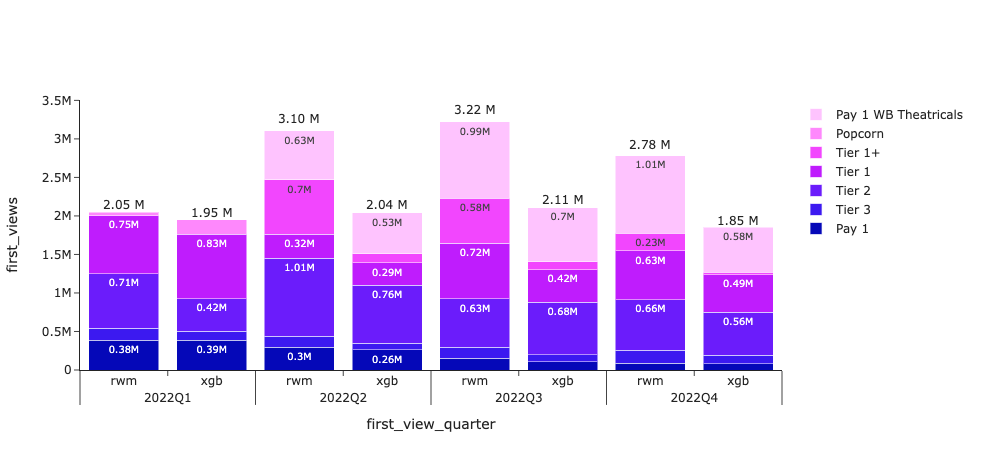

In [29]:
import plotly.graph_objects as go

df_plt = df_pred_future_fv_grp.round()
df_plt = df_plt[(df_plt['first_view_quarter']>'2021Q4') & (df_plt['first_view_quarter']<'2023Q1')]
df_plt['first_view_quarter'] = df_plt['first_view_quarter'].astype(str)


list_quarter = df_plt.first_view_quarter.unique().tolist()
list_tier =df_plt.tier_cat.unique().tolist()

# list_quarter_tier = list(itertools.product(list_quarter, list_tier))
# values = {'2022Q1':{'Pay 1': 0.4, 'Popcorn':0.01, 'Tier 1':1.3, 'Tier 2':0.8, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 0,'Tier 1+':0}
#         ,'2022Q2':{'Pay 1':0.3,'Popcorn':0,'Tier 1':0.5, 'Tier 2':1.2, 'Tier 3':0.2, 'Pay 1 WB Theatricals':1.5, 'Tier 1+':0.7}
#         ,'2022Q3':{'Pay 1':0.1, 'Popcorn':0, 'Tier 1':1.0, 'Tier 2':0.7, 'Tier 3':0.2, 'Pay 1 WB Theatricals':1.8, 'Tier 1+':0.6}
#         , '2022Q4': {'Pay 1':0.1,'Popcorn':0,'Tier 1':1.1, 'Tier 2':0.8, 'Tier 3':0.2, 'Pay 1 WB Theatricals':1.2, 'Tier 1+':0.2}
#          ,'2023Q1':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':0.6, 'Tier 2':0.6, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 1.3,'Tier 1+':0.7}
#          ,'2023Q2':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.1, 'Tier 2':0.8, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 1,'Tier 1+':0.6}
#          ,'2023Q3':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':1.4, 'Tier 2':0.7, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 2.7,'Tier 1+':0.6}
#          ,'2023Q4':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.6, 'Tier 2':0.5, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 2.2,'Tier 1+':1.1}
#          ,'2024Q1':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':1.9, 'Tier 2':0.9, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 1.8,'Tier 1+':0.9}
#          ,'2024Q2':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':1.9, 'Tier 2':0.5, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 1.9,'Tier 1+':0.8}
#          ,'2024Q3':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.1, 'Tier 2':0.5, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 2.0,'Tier 1+':1.4}
#          ,'2024Q4':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.1, 'Tier 2':0.4, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 1.9,'Tier 1+':1.7}}
# for i in list_quarter:
#     for j in list_tier:
#         df_plt.loc[(df_plt.model=='rwm') & (df_plt.first_view_quarter==i) &\
#                    (df_plt.tier_cat==j), 'first_views'] = values[i][j]*1000000


df_plt['total'] = df_plt.groupby(by=['model','first_view_quarter']).first_views.transform('sum')
df_plt['text'] = df_plt['first_views']/1000000 
df_plt['text'] = df_plt['text'].round(2)
df_plt['text'] = df_plt['text'].astype(str) + 'M'

fig = go.Figure()


tier_cat_list = ['Pay 1', 'Tier 3','Tier 2','Tier 1','Tier 1+','Popcorn','Pay 1 WB Theatricals',]  ## px.colors.sequential.Plotly3


n=0
for r, c in zip(tier_cat_list,  ['#0508b8','#3c19f0','#6b1cfb','#bf1cfd','#f246fe','#fe88fc','#fec3fe']):
    plot_df = df_plt[df_plt.tier_cat == r]
    fig.add_trace(
        go.Bar(x=[plot_df.first_view_quarter, plot_df.model], y=plot_df.first_views, name=r, marker_color=c, 
               text=plot_df.text, textposition='inside',  textangle=0) ,
    )
    
annotation=[]    
quarters=df_plt.first_view_quarter.unique().tolist()
models = ['xgb','rwm']
for q, m in itertools.product(quarters, models):
    plot_df = df_plt[(df_plt.first_view_quarter==q) & (df_plt.model==m)]    
    dic= {"x":[q, m], "y": plot_df.first_views.sum()*1.05,
                 "text": f'{plot_df.first_views.sum()/1000000:.2f} M', 
                 "showarrow": False} 
    annotation.append(dic)
    n+=1


fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="first_view_quarter"),
    yaxis=dict(title_text="first_views"),
    barmode="stack",
    uniformtext_minsize=8, 
    uniformtext_mode='hide',
    annotations=annotation
)

fig


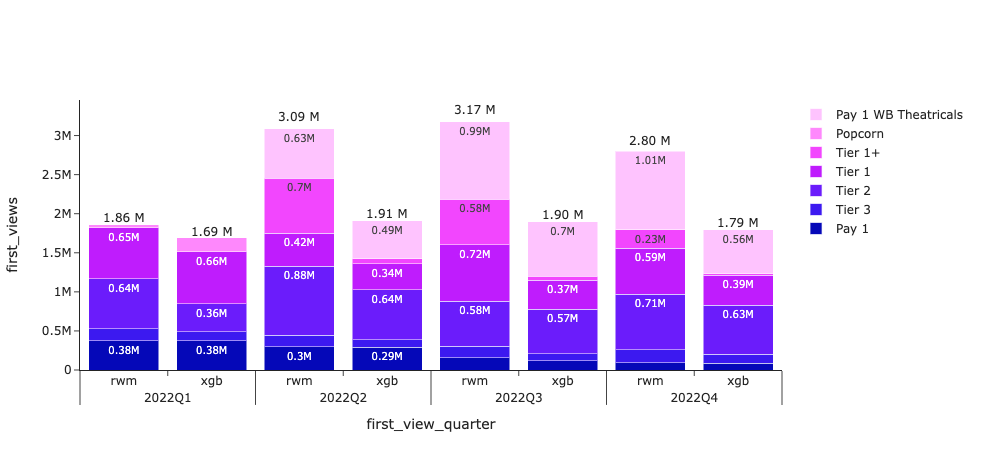

In [20]:
Beta

In [ ]:
Q2:  Pay1 WB Theatrical:  Fantastic beasts 
Q3:  Tier 1+ House of dragon 
    Tier 1 Father of the bride LatinX, Batgirl 
Q4  Pay 1 WB Theatrical: The flash, black adam  (100-200K in xgb, ~ 500k in rwm)
    Tier 1+:  House of dragon  (300K in xgb, 800k in rwm )
    Tier 1: Father of the bride LatinX, Batgirl
    


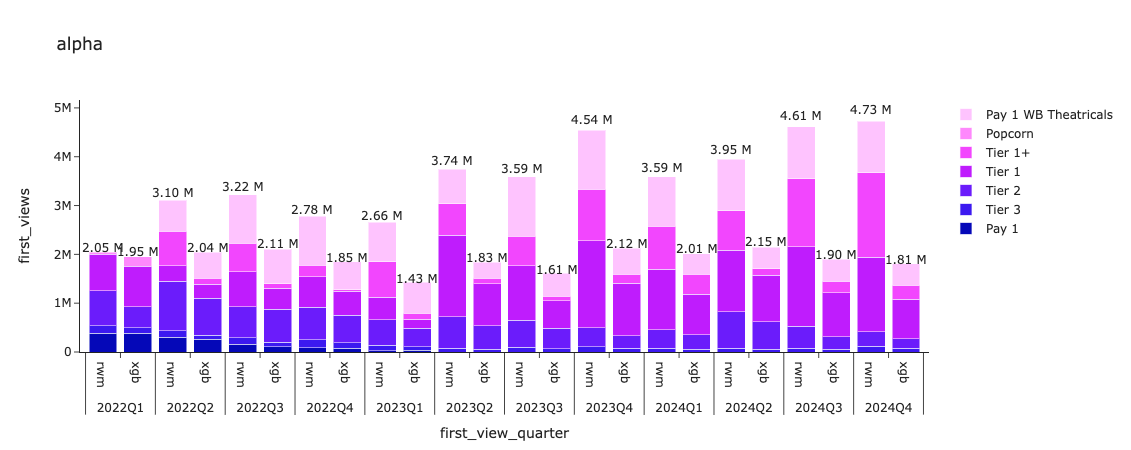

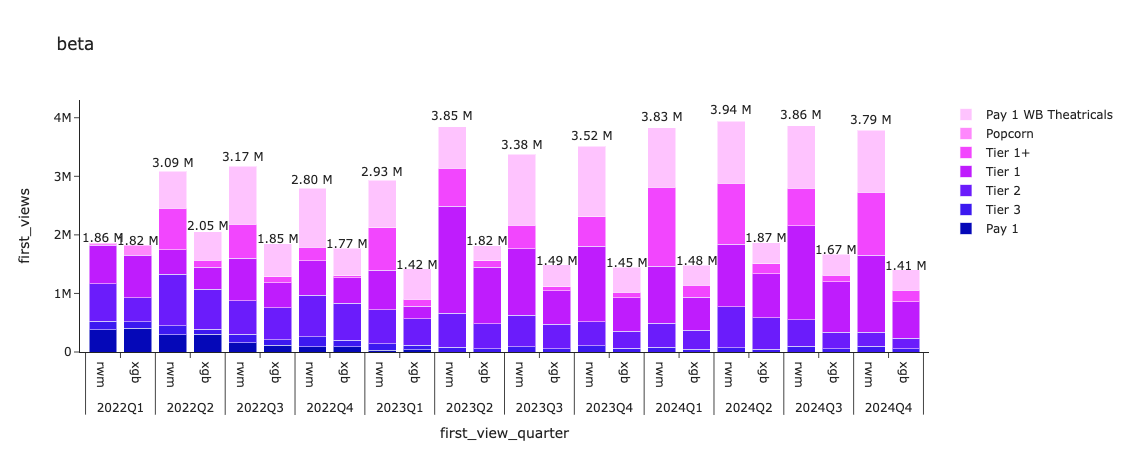

In [57]:
import plotly.graph_objects as go

df_plt = df_pred_future_fv_grp.round()
df_plt = df_plt[(df_plt['first_view_quarter']>'2021Q4') & (df_plt['first_view_quarter']<'2025Q1')]
df_plt['first_view_quarter'] = df_plt['first_view_quarter'].astype(str)
list_quarter = df_plt.first_view_quarter.unique().tolist()
list_tier =df_plt.tier_cat.unique().tolist()

# list_quarter_tier = list(itertools.product(list_quarter, list_tier))
# values = {'2022Q1':{'Pay 1': 0.4, 'Popcorn':0.01, 'Tier 1':1.3, 'Tier 2':0.8, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 0,'Tier 1+':0}
#         ,'2022Q2':{'Pay 1':0.3,'Popcorn':0,'Tier 1':0.5, 'Tier 2':1.2, 'Tier 3':0.2, 'Pay 1 WB Theatricals':1.5, 'Tier 1+':0.7}
#         ,'2022Q3':{'Pay 1':0.1, 'Popcorn':0, 'Tier 1':1.0, 'Tier 2':0.7, 'Tier 3':0.2, 'Pay 1 WB Theatricals':1.8, 'Tier 1+':0.6}
#         , '2022Q4': {'Pay 1':0.1,'Popcorn':0,'Tier 1':1.1, 'Tier 2':0.8, 'Tier 3':0.2, 'Pay 1 WB Theatricals':1.2, 'Tier 1+':0.2}
#          ,'2023Q1':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':0.6, 'Tier 2':0.6, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 1.3,'Tier 1+':0.7}
#          ,'2023Q2':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.1, 'Tier 2':0.8, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 1,'Tier 1+':0.6}
#          ,'2023Q3':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':1.4, 'Tier 2':0.7, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 2.7,'Tier 1+':0.6}
#          ,'2023Q4':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.6, 'Tier 2':0.5, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 2.2,'Tier 1+':1.1}
#          ,'2024Q1':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':1.9, 'Tier 2':0.5, 'Tier 3':0.1, 'Pay 1 WB Theatricals': 1.8,'Tier 1+':0.9}
#          ,'2024Q2':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':1.9, 'Tier 2':0.9, 'Tier 3':0.1, 'Pay 1 WB Theatricals': 1.9,'Tier 1+':0.8}
#          ,'2024Q3':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.1, 'Tier 2':0.5, 'Tier 3':0.2, 'Pay 1 WB Theatricals': 2.0,'Tier 1+':1.4}
#          ,'2024Q4':{'Pay 1': 0, 'Popcorn':0, 'Tier 1':2.1, 'Tier 2':0.4, 'Tier 3':0.1, 'Pay 1 WB Theatricals': 1.9,'Tier 1+':1.7}}
# for i in list_quarter:
#     for j in list_tier:
#         df_plt.loc[(df_plt.model=='rwm') & (df_plt.first_view_quarter==i) &\
#                    (df_plt.tier_cat==j), 'first_views'] = values[i][j]*1000000


df_plt['total'] = df_plt.groupby(by=['model','first_view_quarter']).first_views.transform('sum')
df_plt['text'] = df_plt['first_views']/1000000 
df_plt['text'] = df_plt['text'].round(2)
df_plt['text'] = df_plt['text'].astype(str) + 'M'

fig = go.Figure()


tier_cat_list = ['Pay 1', 'Tier 3','Tier 2','Tier 1','Tier 1+','Popcorn','Pay 1 WB Theatricals',]  ## px.colors.sequential.Plotly3


for r, c in zip(tier_cat_list,  ['#0508b8','#3c19f0','#6b1cfb','#bf1cfd','#f246fe','#fe88fc','#fec3fe']):
    plot_df = df_plt[df_plt.tier_cat == r]
    fig.add_trace(
        go.Bar(x=[plot_df.first_view_quarter, plot_df.model], y=plot_df.first_views, name=r, marker_color=c, 
               text=plot_df.first_views, textposition='inside', textangle=0) ,
    )

    
annotation=[]    
quarters=df_plt.first_view_quarter.unique().tolist()
models = ['xgb','rwm']
for q, m in itertools.product(quarters, models):
    plot_df = df_plt[(df_plt.first_view_quarter==q) & (df_plt.model==m)]    
    dic= {"x":[q, m], "y": plot_df.first_views.sum()*1.05,
                 "text": f'{plot_df.first_views.sum()/1000000:.2f} M', 
                 "showarrow": False} 
    annotation.append(dic)
    n+=1


fig.update_layout(
    title=f'{label}',
    template="simple_white",
    xaxis=dict(title_text="first_view_quarter"),
    yaxis=dict(title_text="first_views"),
    barmode="stack",
    uniformtext_minsize=8, 
    uniformtext_mode='hide',
    annotations=annotation
)

fig


In [131]:
df_pred_future_in['start_month'] = df_pred_future_in['effective_start_date'].dt.to_period('M').dt.to_timestamp()
df_rwm['start_month'] = df_rwm['effective_start_date'].dt.to_period('M').dt.to_timestamp()

print(df_pred_future_in[(df_pred_future_in.effective_start_date>='2022-01-01') & (df_pred_future_in.effective_start_date<'2022-05-01')].groupby(by=['tier','start_month']).agg({'title_name':'nunique'}))
print(df_rwm[(df_rwm.effective_start_date>='2022-01-01') & (df_rwm.effective_start_date<'2022-05-01')].groupby(by=['tier','start_month']).agg({'title_name':'nunique'}))



                  title_name
tier start_month            
1    2022-01-01            2
     2022-02-01            1
     2022-04-01            1
2    2022-01-01            1
     2022-03-01            2
     2022-04-01            1
3    2022-01-01            2
     2022-02-01            2
     2022-04-01            2
                  title_name
tier start_month            
1    2022-01-01            5
     2022-02-01            1
     2022-03-01            3
     2022-04-01            1
2    2022-01-01            5
     2022-02-01            5
     2022-03-01           14
     2022-04-01            7
3    2022-01-01           14
     2022-02-01           16
     2022-03-01           11
     2022-04-01           12


In [47]:
### Publish to output table 


def cvdf_to_snowflake(df, table_name):
    stage = '@HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV'
    output_bucket = "hbo-outbound-datascience-content-dev"
    filename ='psi/' + table_name + '.csv'
    dbname, schema = 'MAX_DEV', 'WORKSPACE'
    
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

    print ('Create Table: ' + table_name)
    run_query('''
    create or replace table {table_name}(
    title_name varchar,
    season_number int, 
    content_category  varchar,
    category varchar,
    tier varchar,
    premiere_date varchar,
    first_view_month varchar,
    imdb_prequel_count int,
    imdb_prequel_references int,
    first_views_pred float,
    schedule_label varchar,
    model_train_date varchar
    )
    '''.format(table_name = table_name), dbname, schema)

    print ('Begin Uploading')
    run_query('''
    insert into max_dev.workspace.{table_name}

    select 
          $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12   
    from {stage}/psi/{file_name}

     (FILE_FORMAT => csv_v2)

    '''.format(stage = stage, table_name = table_name,
              file_name = table_name+'.csv')
            , dbname, schema)

    print ('Finish Uploading')    


def run_query(query, dbname, schema):
    SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

    conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
    ctx=conn.connect(dbname,schema)
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df


    
dic_rename = {'effective_start_date':'premiere_date', 
              'ref_tot':'imdb_prequel_count', 'ref_ref_tot':'imdb_prequel_references',
             'first_views_decay_dev_b':'first_views_pred'}

out_col = ['title_name',  'season_number','content_category', 'category',
           'tier', 'premiere_date','first_view_month', 
           'imdb_prequel_count', 'imdb_prequel_references', 'first_views_pred', 'model_train_date']


grpby_title= out_col.copy()
agg_var = 'first_view_month'
grpby_title.remove('first_views_pred')
grpby_title.remove(agg_var)

df_pred_future_out = df_pred_decay_future.rename(columns=dic_rename)
df_pred_future_out = get_agg_first_views(df_pred_future_out, agg_var, grpby_title,'request_date', ['first_views_pred'])
df_pred_future_out = df_pred_future_out[out_col]
df_pred_future_out['schedule_label'] = label
## QA 
display(df_pred_future_out.head())
a = df_pred_future_out.groupby(by=['title_name','category','tier','premiere_date']).sum().reset_index()
# a[a.category=='Pay 1 WB Theatricals']

print(a.premiere_date.min(),a.premiere_date.max()) 
print(a.shape, a.title_name.nunique())

## Upload to snowflake 

import io
df_pred_future_out.to_csv(f's3://datascience-hbo-users/users/tjung/psi/future_program_xgb_pred_{label}.csv')




,title_name,season_number,content_category,category,tier,premiere_date,first_view_month,imdb_prequel_count,imdb_prequel_references,first_views_pred,model_train_date,schedule_label
0,100 Foot Wave,2,series,Docu-Series,3,2022-07-27,2022-07-01,0.0,0.0,826.182264,2021-09-01,alpha
1,100 Foot Wave,2,series,Docu-Series,3,2022-07-27,2022-08-01,0.0,0.0,2436.447416,2021-09-01,alpha
2,100 Foot Wave,2,series,Docu-Series,3,2022-07-27,2022-09-01,0.0,0.0,529.224951,2021-09-01,alpha
3,100 Foot Wave,2,series,Docu-Series,3,2022-07-27,2022-10-01,0.0,0.0,169.078963,2021-09-01,alpha
4,12 Dates of Christmas,2,series,Unscripted Series,3,2021-11-25,2021-11-01,0.0,0.0,1001.730684,2021-09-01,alpha


2021-11-04 00:00:00 2024-12-19 00:00:00
(751, 8) 604


In [48]:
out_col = ['title_name',  'season_number','content_category', 'category',
           'tier', 'premiere_date','first_view_month', 
           'imdb_prequel_count', 'imdb_prequel_references', 'first_views_pred', 'schedule_label', 'model_train_date']

df_beta = pd.read_csv(f's3://datascience-hbo-users/users/tjung/psi/future_program_xgb_pred_beta.csv')
df_alpha = pd.read_csv(f's3://datascience-hbo-users/users/tjung/psi/future_program_xgb_pred_alpha.csv')

df_pred_future_out = pd.concat([df_beta[out_col], df_alpha[out_col]])
df_pred_future_out.to_csv(f's3://datascience-hbo-users/users/tjung/psi/future_program_xgb_pred.csv')

cvdf_to_snowflake(df_pred_future_out, 'future_program_xgb_pred')

Create Table: future_program_xgb_pred
Begin Uploading
Finish Uploading


In [25]:
df_raw[df_raw.category=='Popcorn'].groupby(by=['tier','start_year_month','effective_start_date','title_name'])[['first_views']].sum()

first_views
tier start_year_month effective_start_date title_name                                         
1    2020-12          2020-12-25           Wonder Woman 1984                           2727097
     2021-03          2021-03-31           Godzilla vs. Kong                           2017166
     2021-04          2021-04-23           Mortal Kombat                               1074955
     2021-07          2021-07-16           Space Jam: A New Legacy                      668908
     2021-08          2021-08-05           The Suicide Squad                            550432
2    2021-01          2021-01-29           The Little Things                            635584
     2021-02          2021-02-12           Judas and the Black Messiah                  319734
                      2021-02-26           Tom & Jerry                                  595704
     2021-05          2021-05-14           Those Who Wish Me Dead                       153250
     2021-06          2021-06-04           The Conjuring: The Devil Made Me Do It       571118
                      2021-06-10           In the Heights                               195243
     2021-08          2021-08-20           Reminiscence                                  68705

## N Months Evaluation

In [87]:
def get_filtered_first_views(df_in, offset, grpby_title, first_view_date_col):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting next 3 months? 
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()

    ## select rows where first_view_months are within offset months + prediction date
    df_in = df_in[(df_in['first_view_month']<= df_in['pred_date'] + pd.DateOffset(months=offset))]  
    return df_in
    
def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in


agg_var = 'pred_date'
offset = 2

#### Get actuals & xgb prediction 
postfix = 'dev_b'
grpby_title= ['title_name', 'tier','season_number','category']

df_pred_decay_=df_pred_decay.merge(df_raw[['title_name','category','effective_start_date','request_date','first_views']], on=['title_name','category','effective_start_date','request_date'], suffixes=['','_actual'], how='left')
df_pred_decay_ = get_filtered_first_views(df_pred_decay_, offset, grpby_title, 'request_date')
df_pred_dev_b = get_agg_first_views(df_pred_decay_, agg_var, grpby_title, 'request_date', [f'first_views_decay_{postfix}', 'first_views_actual'])


### Get baseline 
## Get raw data 
df_median_mx_raw = []
for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801', '210901'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['pred_date'] = date_start
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['premiere_month'] = df_temp['premiere_date'].dt.to_period('M').dt.to_timestamp()
    df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
    df_temp = df_temp[df_temp['premiere_date'] >= df_temp['pred_date']]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)

df_median_mx = get_filtered_first_views(df_median_mx_raw, offset, grpby_title+['premiere_month'], 'seq_date')
df_median_mx = get_agg_first_views(df_median_mx, agg_var, grpby_title+['premiere_month'], 'seq_date', ['predicted_first_views'])

# Match title name to titles in actuals 
df_title = df_median_mx_raw[grpby_title].drop_duplicates(subset=['title_name'])
df_title['title_name_match'] = df_title['title_name'].apply(lambda x: process.extractOne(x, list(df_pred_dev_b['title_name'].unique()), score_cutoff=90))
name_from_df2_list = df_title['title_name_match'].to_list()
name_from_df2_list = [_[0] if _ != None else None for _ in name_from_df2_list]
df_title['title_name_match'] = name_from_df2_list
df_title.loc[df_title.title_name=='Euphoria Special Episode Part Two', 'title_name_match'] = 'Euphoria Special Episode Part 2: Jules'
df_title.loc[df_title.title_name.str.contains('Juan Luis'), 'title_name_match'] = 'Juan Luis Guerra 4.40: Entre Mar y Palmeras'
df_title.loc[df_title.title_name.str.contains('Real Time'), 'title_name_match'] = 'Real Time with Bill Maher'
df_title.loc[df_title.title_name.str.contains('Last Week Tonight'), 'title_name_match'] = 'Last Week Tonight with John Oliver'

## Merge titles and seasons 
df_median_mx = df_median_mx.merge(df_title[['title_name','title_name_match']], how='left', on=['title_name'])
df_median_mx['title_name_fp'] = df_median_mx['title_name']
df_median_mx['title_name'] = df_median_mx['title_name_match']

# Fill in seasons 
df_title_season = df_pred_dev_b.drop_duplicates(subset=['title_name','season_number'])
df_median_mx_season = df_median_mx[df_median_mx.season_number!=0]
df_median_mx_noseason = df_median_mx[df_median_mx.season_number==0]
df_median_mx_noseason = df_median_mx_noseason.merge(df_title_season[['title_name','season_number']], on=['title_name'])
df_median_mx_noseason['season_number'] = df_median_mx_noseason['season_number_y'] 
df_median_mx = pd.concat([df_median_mx_season,df_median_mx_noseason[df_median_mx_season.columns]])
print(df_median_mx.shape)
df_median_mx = df_median_mx.drop_duplicates(subset=['title_name','season_number', agg_var])
print(df_median_mx.shape)

## Merge actual, median baseline and prediction 
df_eval = df_pred_dev_b.merge(df_median_mx, on=['title_name', 'category','season_number', agg_var], how='inner')
print(df_eval.title_name.nunique())
print(df_eval.isnull().sum())
print(df_eval[df_eval.title_name_match.isnull()].title_name.nunique())
print(df_eval[df_eval.first_views_decay_dev_b.isnull()].title_name.nunique())
print(df_eval.columns)
df_eval = df_eval[df_eval.title_name!='Tenet']
df_eval['tier'] = df_eval['tier_x']

(397, 9)
(345, 9)
98
title_name                 0
tier_x                     0
season_number              0
category                   0
pred_date                  0
first_views_decay_dev_b    0
first_views_actual         0
tier_y                     0
premiere_month             0
predicted_first_views      0
title_name_match           0
title_name_fp              0
dtype: int64
0
0
Index(['title_name', 'tier_x', 'season_number', 'category', 'pred_date',
       'first_views_decay_dev_b', 'first_views_actual', 'tier_y',
       'premiere_month', 'predicted_first_views', 'title_name_match',
       'title_name_fp'],
      dtype='object')


In [176]:
file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_210901.csv'
df_temp = pd.read_csv(file_path)

df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
df_temp['pred_date'] = '2021-09-01'
df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
df_temp = df_temp[(df_temp['premiere_date'] >= df_temp['pred_date']) & (df_temp['premiere_date'] <='2021-10-01')]

df_temp.title_name.unique()

df_temp

array(['Adventure Time: Distant Lands 4 "Wizard City"', 'Malignant',
       'Scenes From A Marriage', 'Level Playing Field',
       'Promising Young Woman', 'Death on the Nile', 'News of the World',
       'The Not-Too-Late Show With Elmo', 'Ten-Year-Old Tom',
       'Entre Hombres', 'Little Ellen', 'Tig N Seek', 'Huesped Americano',
       'The Way Down', 'Nuclear Family', 'Ahir Shah: Dots', 'Doom Patrol',
       'Yabba Dabba Dinosaurs', 'Cry Macho'], dtype=object)

In [186]:
df_pred_dev_b[df_pred_dev_b.pred_date=='2021-09-01']

,title_name,tier,season_number,category,pred_date,first_views_decay_dev_b,first_views_actual
8,Ahir Shah: Dots,3,0,Specials,2021-09-01,1728.910554,2792
28,Cry Macho,1,0,Popcorn,2021-09-01,145315.625000,133022
33,Entre hombres (Amongst Men),3,1,International,2021-09-01,1280.386419,24
127,Malignant,1,0,Popcorn,2021-09-01,145315.625000,136814
137,Mortal Kombat,1,0,Pay1,2021-09-01,90525.620101,67030
143,News of the World,3,0,Pay1,2021-09-01,5705.297352,23399
149,Nuclear Family,3,1,Docu-Series,2021-09-01,3754.016040,1619
168,Promising Young Woman,3,0,Pay1,2021-09-01,5280.571830,9795
199,The American Guest (El huésped americano),3,1,International,2021-09-01,1285.474047,876
237,The Many Saints of Newark,1,0,Popcorn,2021-09-01,381327.812500,235860


In [10]:
df_eval[(df_eval.category=='Specials') & (df_eval.premiere_month==df_eval.pred_date)].groupby(by=['title_name','tier','season_number','category']).sum()

,,,,tier_x,first_views_decay_dev_b,first_views_actual,tier_y,predicted_first_views
title_name,tier,season_number,category,,,,,
Ahir Shah: Dots,3,0,Specials,3,1711.009447,2792,3,4042.0
Friends: The Reunion,1,0,Specials,1,254026.086237,850948,1,110140.0
Marlon Wayans: You Know What It Is,3,0,Specials,3,1788.054388,8006,3,3288.0
Tig Notaro: Drawn,3,0,Specials,3,1856.705165,1994,3,3556.0


In [78]:
Mar: Scripted Feature  Zach Snyder 
Apr : Specials 
May : Specials 
June-Aug  Scripted Drama Series	
df_eval[df_eval.tier==1].groupby(by=['pred_date','category']).sum()

tier_x  season_number  \
pred_date  category                                       
2021-03-01 Popcorn                     1              0   
           Scripted Drama Series       2              2   
           Scripted Features           1              0   
           Specials                    1              0   
2021-04-01 Popcorn                     3              0   
           Scripted Drama Series       2              2   
           Specials                    1              0   
2021-05-01 Popcorn                     3              0   
           Scripted Drama Series       1              1   
           Specials                    1              0   
2021-06-01 Popcorn                     3              0   
           Scripted Drama Series       2              4   
2021-07-01 Popcorn                     1              0   
           Scripted Drama Series       2              4   
2021-08-01 Popcorn                     1              0   
           Scripted Drama Series       1              3   

                                  first_views_decay_dev_b  first_views_actual  \
pred_date  category                                                             
2021-03-01 Popcorn                           1.443775e+05              120576   
           Scripted Drama Series             3.575758e+05              146248   
           Scripted Features                 3.870488e+05             1139180   
           Specials                          1.193310e+05              553161   
2021-04-01 Popcorn                           1.448043e+06              852959   
           Scripted Drama Series             2.781086e+05              224733   
           Specials                          8.580068e+04              806612   
2021-05-01 Popcorn                           1.067626e+06              917812   
           Scripted Drama Series             5.378597e+04               67657   
           Specials                          5.635775e+04              850948   
2021-06-01 Popcorn                           1.090684e+06              803359   
           Scripted Drama Series             4.779533e+04              119564   
2021-07-01 Popcorn                           2.720088e+05               68787   
           Scripted Drama Series             8.315237e+04              166302   
2021-08-01 Popcorn                           1.425894e+05               68787   
           Scripted Drama Series             1.682232e+04               80471   

                                  tier_y  predicted_first_views  tier  
pred_date  category                                                    
2021-03-01 Popcorn                     2               192940.0     1  
           Scripted Drama Series       2              1029736.0     2  
           Scripted Features           1               506008.0     1  
           Specials                    1                51406.0     1  
2021-04-01 Popcorn                     6              1436963.0     3  
           Scripted Drama Series       2              1160915.0     2  
           Specials                    1                99793.0     1  
2021-05-01 Popcorn                     6              1531086.0     3  
           Scripted Drama Series       1                91515.0     1  
           Specials                    1               110140.0     1  
2021-06-01 Popcorn                     6               994160.0     3  
           Scripted Drama Series       2               256954.0     2  
2021-07-01 Popcorn                     2               361758.0     1  
           Scripted Drama Series       2               402926.0     2  
2021-08-01 Popcorn                     2               363111.0     1  
           Scripted Drama Series       1               202970.0     1

,pred_date,mae_first_views_decay_median_mx,mae_first_views_decay_dev_b,first_views,first_views_decay_median_mx,first_views_decay_dev_b,pct_error_first_views_decay_median_mx,pct_error_first_views_decay_dev_b
0,2021-03-01,109362.500000,78462.570483,5298915,7767873.0,2.587667e+06,46.593652,-51.166090
1,2021-04-01,75205.023256,46832.644743,3189018,4414580.0,2.957876e+06,38.430702,-7.248073
2,2021-05-01,74037.288889,35482.231903,2707022,4294738.0,2.056950e+06,58.651758,-24.014287
3,2021-06-01,69112.066667,17682.334224,2463680,5041399.0,2.686671e+06,104.628807,9.051120
4,2021-07-01,85342.205128,28051.931496,2086961,5273567.0,2.833405e+06,152.691210,35.767047
5,2021-08-01,80359.409091,23469.485612,1275770,3009623.0,1.418617e+06,135.906394,11.196919
6,2021-09-01,47016.500000,26553.638310,543325,898059.0,7.095219e+05,65.289468,30.588848


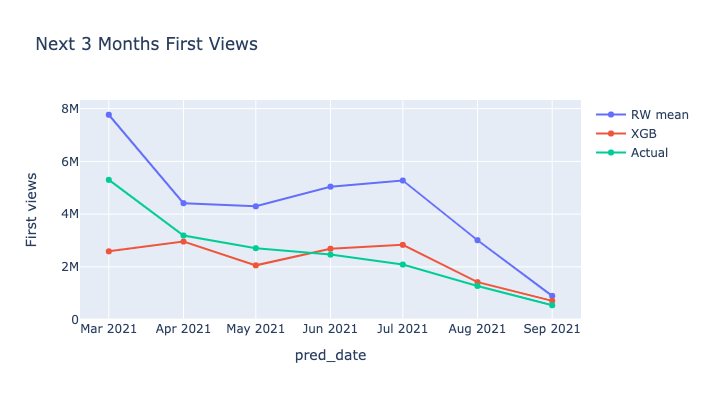

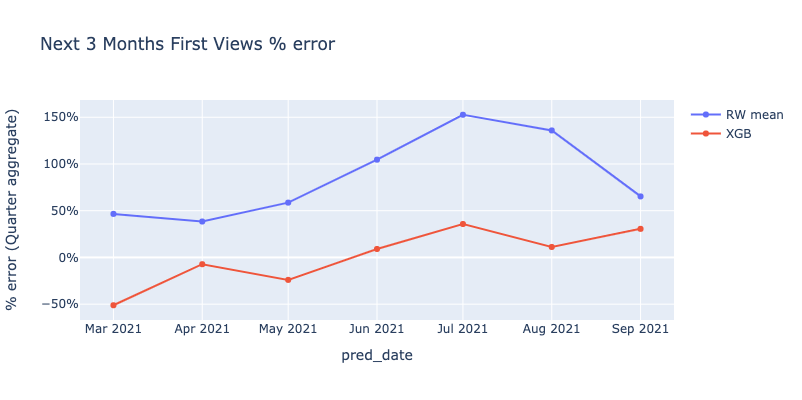

pct_error_first_views_decay_median_mx    86.027427
pct_error_first_views_decay_dev_b        24.147483
dtype: float64

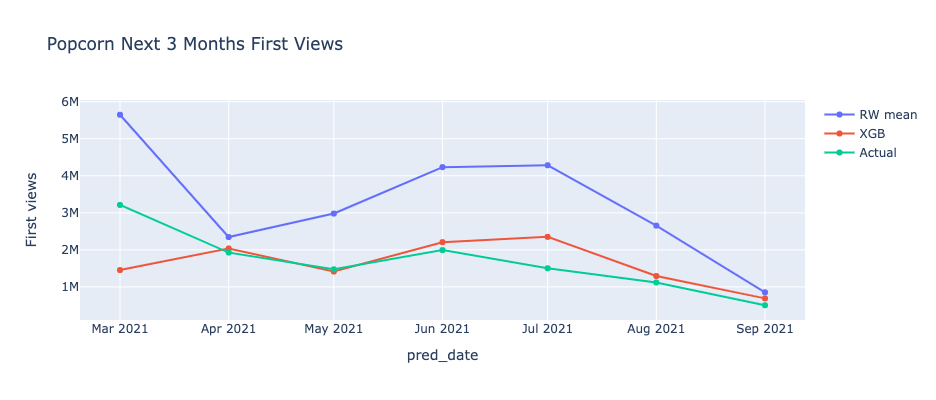

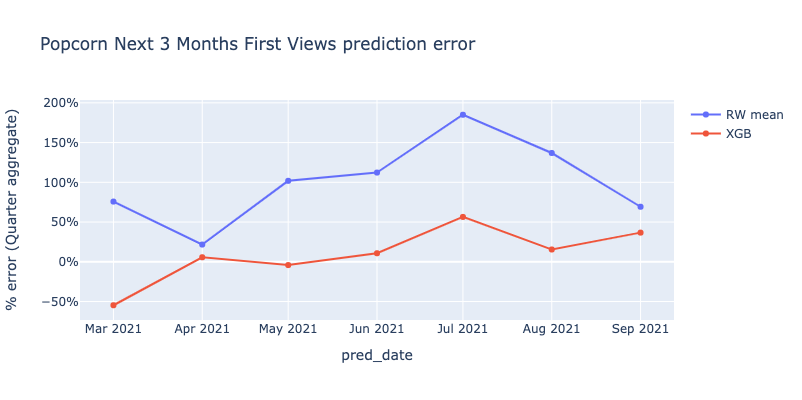

pct_error_first_views_decay_median_mx    100.386101
pct_error_first_views_decay_dev_b         26.267004
dtype: float64

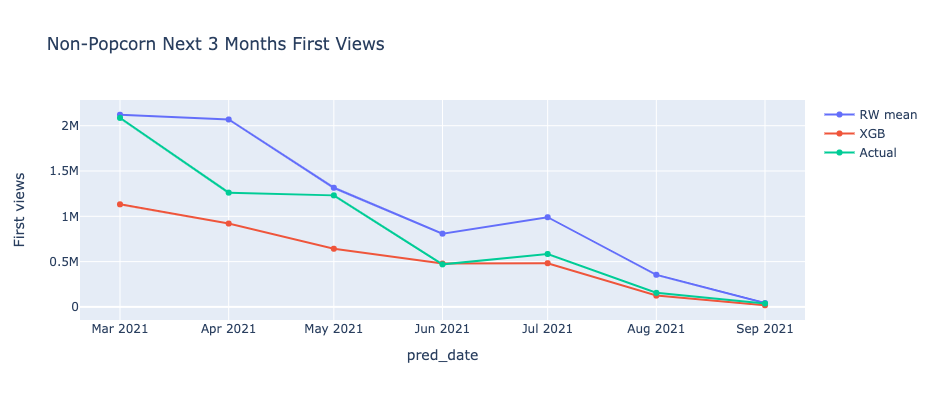

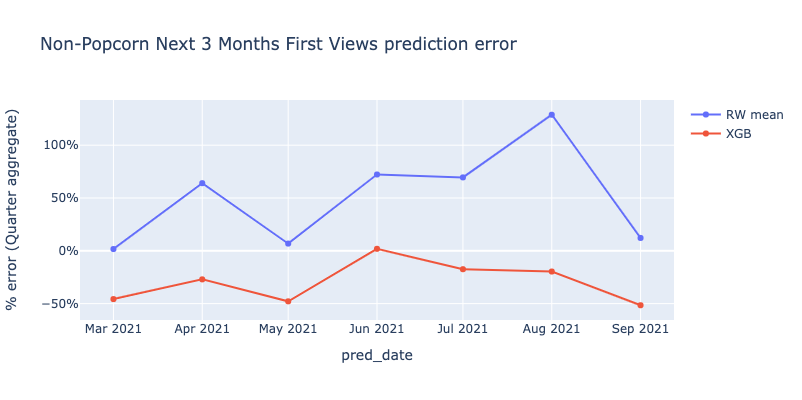

pct_error_first_views_decay_median_mx    50.752055
pct_error_first_views_decay_dev_b        30.160274
dtype: float64

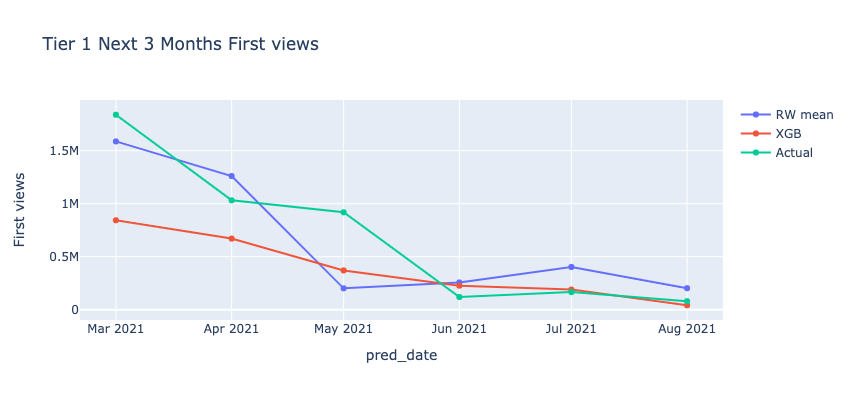

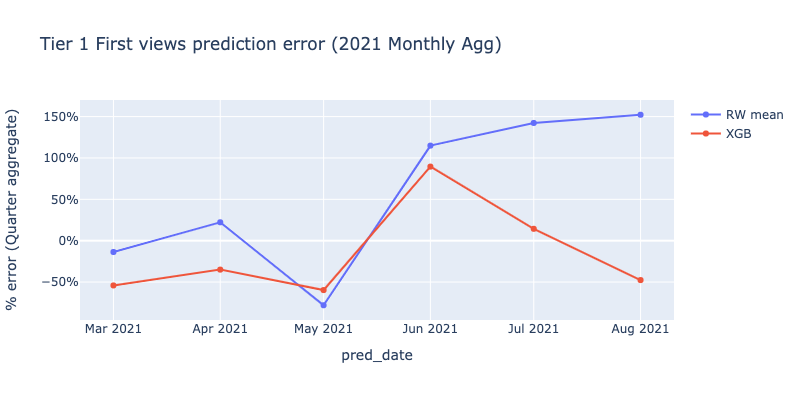

pct_error_first_views_decay_median_mx    87.230826
pct_error_first_views_decay_dev_b        50.050029
dtype: float64

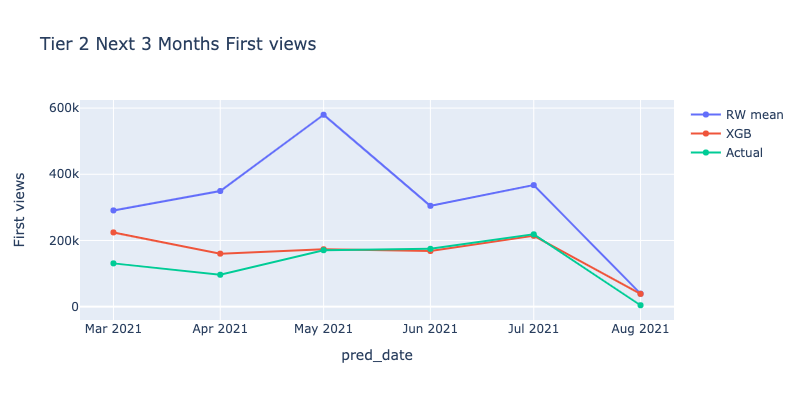

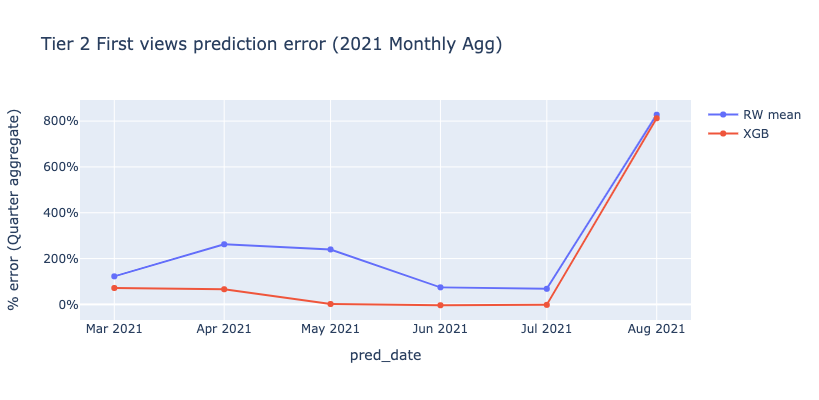

pct_error_first_views_decay_median_mx    153.425669
pct_error_first_views_decay_dev_b         29.011853
dtype: float64

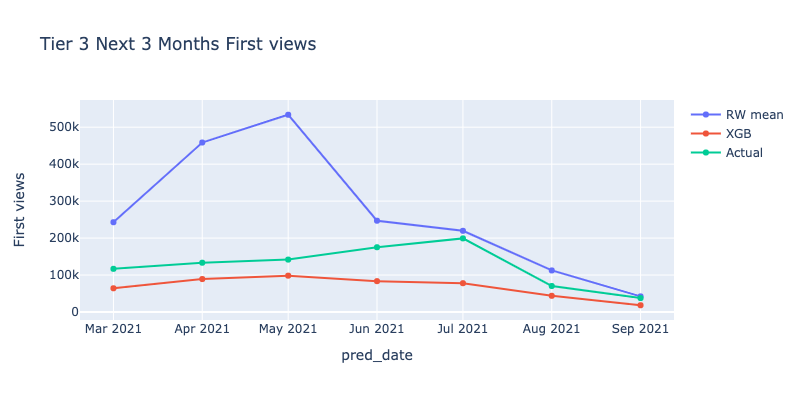

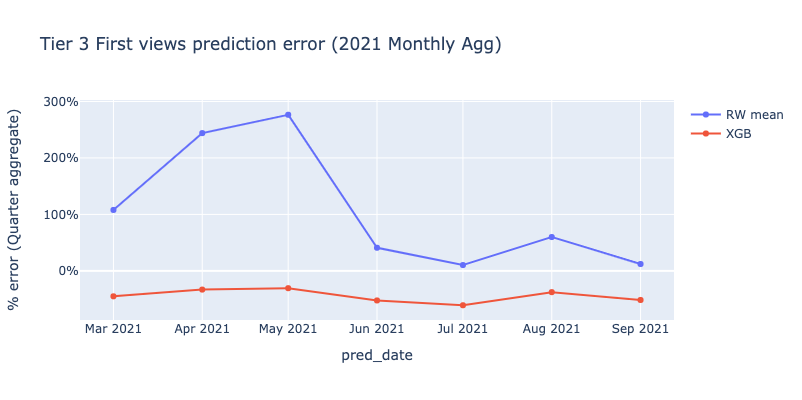

pct_error_first_views_decay_median_mx    107.393079
pct_error_first_views_decay_dev_b         44.483443
dtype: float64

In [24]:
offset = 2
df_eval['first_views'] = df_eval['first_views_actual']
df_eval['first_views_decay_median_mx'] = df_eval['predicted_first_views']
### Plot error 
## Month 
list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
display(df_grp)
# df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
get_pred_plot(df_grp, agg_var,'Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Next 3 Months First Views % error')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

## Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Popcorn Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Popcorn Next 3 Months First Views prediction error ')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

## Non-Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Non-Popcorn Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Non-Popcorn Next 3 Months First Views prediction error ')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

# ## Tiers 
grpby=[agg_var,'tier', 'title_name', 'season_number'] 
df_grp=evaluate_pred_plt(df_eval[(df_eval.category!='Popcorn') & (df_eval.tier==1)], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 Next 3 Months First views')
get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())

df_grp=evaluate_pred_plt(df_eval[(df_eval.category!='Popcorn') & (df_eval.tier==2)], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 Next 3 Months First views')
get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')
display(df_grp[df_grp.pred_date!='2021-08-01'][['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())


df_grp=evaluate_pred_plt(df_eval[(df_eval.category!='Popcorn') & (df_eval.tier==3)], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 Next 3 Months First views')
get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')
display(df_grp[['pct_error_first_views_decay_median_mx','pct_error_first_views_decay_dev_b']].abs().mean())



## Total prediction evaluation

,title_name,title_id,season_number,effective_start_date,tier,content_category,category,first_view_month,first_views
0,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-07-01,5919
1,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-08-01,9000


,title_name,season_number,first_view_month,predicted_first_views,first_views_decay_median_mx,title_name_match,title_name_fp
0,100 Foot Wave,1,2021-07-01,12640.0,12640.0,100 Foot Wave,100 Foot Wave
1,100 Foot Wave,1,2021-08-01,11430.0,11430.0,100 Foot Wave,100 Foot Wave


,title_name,season_number,first_view_month,first_views_decay_dev_b
0,100 Foot Wave,1,2021-07-01,1756.010109
1,100 Foot Wave,1,2021-08-01,1652.596813


divide by zero encountered in log


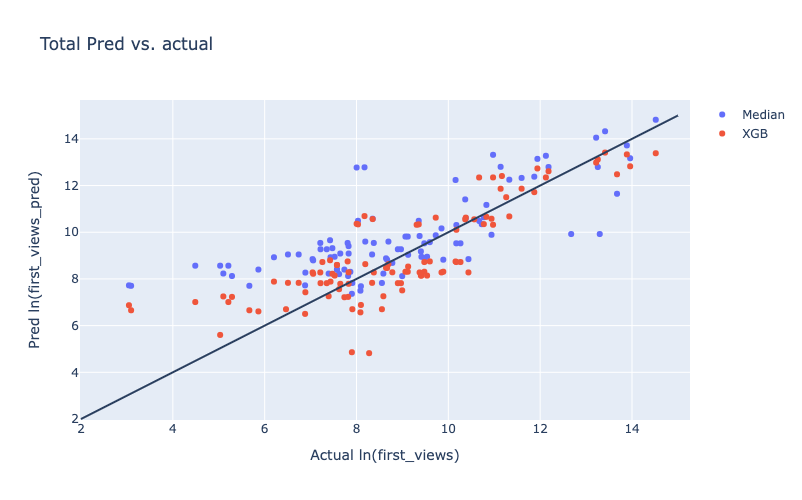


_____________________________________________________________
Aggregate actuals: Count: 137; Title-level mean: 79550;  Aggregate sum: 10898402
decay_median_mx title-level MAE: 72695; aggregate %error: 16%; pred: 12636481; 
decay_dev_b title-level MAE: 51444; aggregate %error: -42%; pred: 6370611; 
Popcorn

_____________________________________________________________
Aggregate actuals: Count: 11; Title-level mean: 622879;  Aggregate sum: 6851674
decay_median_mx title-level MAE: 465781; aggregate %error: 20%; pred: 8200541; 
decay_dev_b title-level MAE: 357059; aggregate %error: -47%; pred: 3650677; 
Tier1

_____________________________________________________________
Aggregate actuals: Count: 11; Title-level mean: 243200;  Aggregate sum: 2675202
decay_median_mx title-level MAE: 267933; aggregate %error: -8%; pred: 2470384; 
decay_dev_b title-level MAE: 189790; aggregate %error: -31%; pred: 1856433; 
Tier2

_____________________________________________________________
Aggregate actuals

In [26]:
def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i, j in zip(['decay_median_mx'] + list_postfix, ['Median', 'XGB']):
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=j,
                    text= df_plt['effective_start_date'].astype(str) + " " + df_plt['title_name'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=550,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return fig

import plotly.io as pio

def get_agg_first_views(df_in, grpby_title, agg_col, request_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[request_date_col] = pd.to_datetime(df_in[request_date_col])
    df_in['first_view_quarter'] = df_in[request_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[request_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()

    return df_in


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')


# Get actuals & baseline 
agg_var = 'first_view_month'

# ## Get actuals 
grpby_title= ['title_name', 'title_id', 'season_number', 'effective_start_date', 'tier','content_category','category']
df_eval_actuals = df_raw[(df_raw.effective_start_date>='2021-01-01') & (df_raw.effective_start_date<'2021-09-01')].copy()
df_eval_actuals = get_agg_first_views(df_eval_actuals, grpby_title, agg_var,'request_date', 'first_views', 'actual')

## Get Median model baseline. pred = 1 month  
# df_median_mx_raw = []
# for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801'], 
#                             ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
#     file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
#     df_temp = pd.read_csv(file_path)
#     df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
#     df_temp['premiere_month'] = df_temp['premiere_date'].dt.to_period('M').dt.to_timestamp()
#     df_temp = df_temp[df_temp.premiere_date.dt.strftime('%Y-%m')== datetime.strptime(date_start, '%Y-%m-%d').strftime('%Y-%m')]
#     df_median_mx_raw.append(df_temp)
# df_median_mx_raw = pd.concat(df_median_mx_raw)

grpby_title= ['title_name', 'season_number']
# df_title = df_median_mx_raw[grpby_title].drop_duplicates(subset=grpby_title)
# df_title['title_name_match'] = df_title['title_name'].apply(lambda x: process.extractOne(x, df_eval_actuals['title_name'].to_list(), score_cutoff=90))
# name_from_df2_list = df_title['title_name_match'].to_list()
# name_from_df2_list = [_[0] if _ != None else None for _ in name_from_df2_list]
# df_title['title_name_match'] = name_from_df2_list
# df_title.loc[df_title.title_name=='Euphoria Special Episode Part Two', 'title_name_match'] = 'Euphoria Special Episode Part 2: Jules'
# df_title.loc[df_title.title_name.str.contains('Juan Luis'), 'title_name_match'] = 'Juan Luis Guerra 4.40: Entre Mar y Palmeras'

df_median_mx_raw_next = df_median_mx_raw[df_median_mx_raw.premiere_month == df_median_mx_raw.pred_date]
df_median_mx = get_agg_first_views(df_median_mx_raw_next, grpby_title, agg_var, 'seq_date', 'predicted_first_views', 'median_mx')
df_median_mx['first_views_decay_median_mx'] = df_median_mx['predicted_first_views'] 
df_median_mx = df_median_mx.merge(df_title[['title_name','title_name_match']], how='left', on=['title_name'])
df_median_mx['title_name_fp'] = df_median_mx['title_name']
df_median_mx['title_name'] = df_median_mx['title_name_match']

# Fill in seasons 
df_title_season = df_eval_actuals.drop_duplicates(subset=['title_name','season_number'])
df_median_mx_season = df_median_mx[df_median_mx.season_number!=0]
df_median_mx_noseason = df_median_mx[df_median_mx.season_number==0]
df_median_mx_noseason = df_median_mx_noseason.merge(df_title_season[['title_name','season_number']], on=['title_name'])
df_median_mx_noseason['season_number'] = df_median_mx_noseason['season_number_y'] 
df_median_mx = pd.concat([df_median_mx_season,df_median_mx_noseason[df_median_mx_season.columns]])
df_median_mx = df_median_mx.drop_duplicates(subset=['title_name','season_number', agg_var])


# ## Get aggregated xgb prediction 
df_pred_decay_next = df_pred_decay[df_pred_decay.start_month == df_pred_decay.pred_date]    
df_pred_dev_b = get_agg_first_views(df_pred_decay_next, grpby_title, var_agg,'request_date', f'first_views_decay_{postfix}', postfix)

## Merge actual, median baseline and prediction 
display(df_eval_actuals.head(2))
display(df_median_mx.head(2))
display(df_pred_dev_b.head(2))
df_eval = df_eval_actuals.merge(df_median_mx, on=['title_name', 'season_number', agg_var], how='left')\
        .merge(df_pred_dev_b[['title_name','season_number',agg_var,'first_views_decay_dev_b']], on=['title_name','season_number',agg_var], how='left')
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_decay_median_mx_log'] = np.log(df_eval['first_views_decay_median_mx'])
df_eval['first_views_decay_dev_b_log'] = np.log(df_eval['first_views_decay_dev_b'])
# print(df_eval.title_name.nunique())
# print(df_eval.isnull().sum())
# print(df_eval[df_eval.title_name_match.isnull()].title_name.nunique())
# print(df_eval[df_eval.first_views_decay_dev_b.isnull()].title_name.nunique())
# print(df_eval.columns)
# df_eval = df_eval.dropna()


df_eval_title = df_eval.groupby(by=['title_name','season_number','effective_start_date','tier','category'])\
                        [['first_views','first_views_decay_median_mx','first_views_decay_dev_b']].sum().reset_index()
df_eval_title['first_views_log'] = np.log(df_eval_title['first_views'] )
df_eval_title['first_views_decay_median_mx_log'] = np.log(df_eval_title['first_views_decay_median_mx'])
df_eval_title['first_views_decay_dev_b_log'] = np.log(df_eval_title['first_views_decay_dev_b'])

fig = get_pred_actual_plot(df_eval_title, 'Total', ['decay_dev_b'])
evaluate_pred(df_eval_title, ['decay_median_mx','decay_dev_b'])

print('Popcorn')
evaluate_pred(df_eval_title[df_eval_title.category=='Popcorn'], ['decay_median_mx','decay_dev_b'])
print('Tier1')
evaluate_pred(df_eval_title[(df_eval_title.category!='Popcorn') & (df_eval_title.tier==1)], ['decay_median_mx','decay_dev_b'])
print('Tier2')
evaluate_pred(df_eval_title[(df_eval_title.category!='Popcorn') & (df_eval_title.tier==2)], ['decay_median_mx','decay_dev_b'])
print('Tier3')
evaluate_pred(df_eval_title[(df_eval_title.category!='Popcorn') & (df_eval_title.tier==3)], ['decay_median_mx','decay_dev_b'])

In [66]:
# df_pred_decay_next = df_pred_decay[df_pred_decay.start_month == df_pred_decay.pred_date]    
df_eval_title[df_eval_title.title_name.str.contains('Friends')]

,title_name,season_number,effective_start_date,tier,category,first_views,first_views_decay_median_mx,first_views_decay_dev_b,first_views_log,first_views_decay_median_mx_log,first_views_decay_dev_b_log
27,Friends: The Reunion,0,2021-05-27,1,Specials,867873,114426.0,58506.570312,13.673801,11.647684,10.976894
29,Furry Friends Forever: Elmo Gets a Puppy,0,2021-08-05,3,Kids & Family,3247,1803.0,737.677307,8.085487,7.497207,6.603506


## Model diagnosis

2021-09-01 194 (9, 17)


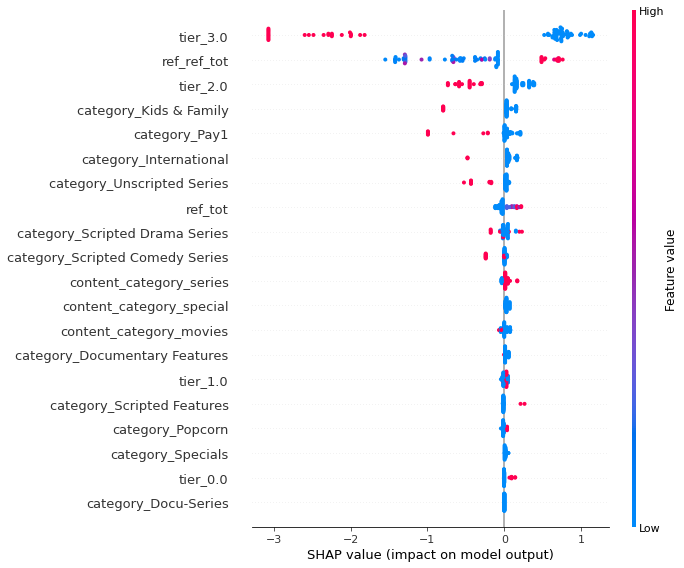

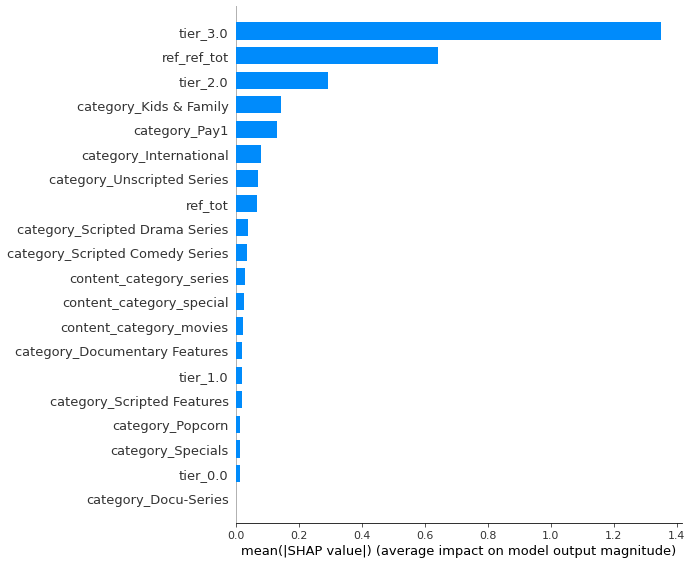

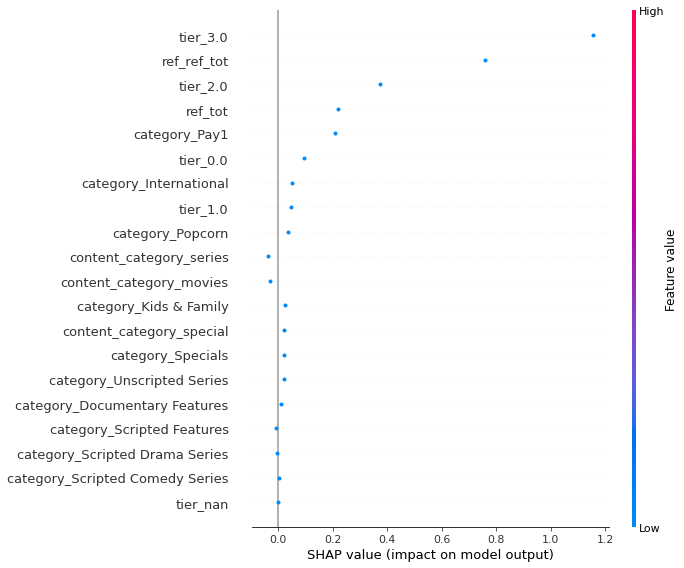

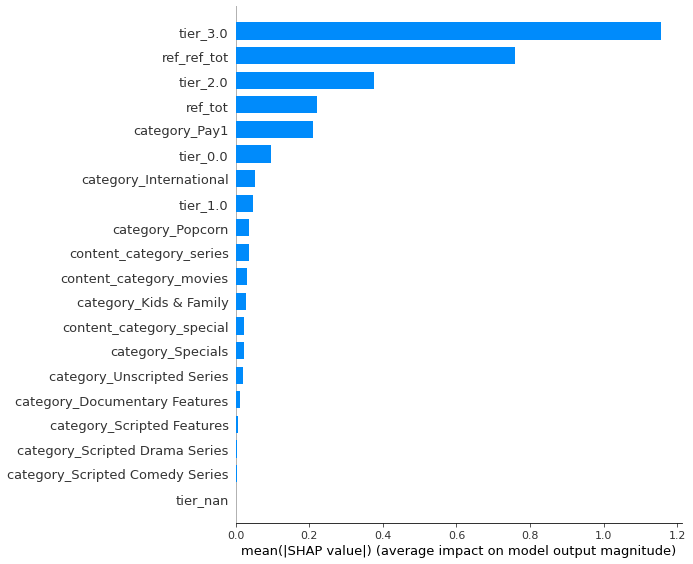

In [92]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

## xgb w/ clean data  
features_cont_dev=[
#     'season_number',
    'ref_ref_tot',
    'ref_tot'
]


df_pred_list = []

var_agg = 'first_view_month'
date_eval_end = '2021-10-01'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-09-01']
date_eval_end = '2021-10-01'
date_pred_future = '2021-09-01'
df_popcorn_decay = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/popcorn_decay_210801.csv')
df_popcorn_decay['first_views_pct_popcorn'] = df_popcorn_decay['first_views_pct']

for title, date_pred in zip(['Matrix'],['2021-09-01']):
#     ## Train
    df_train_in = df_actual[(df_actual.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in.loc[df_train_in.first_views>1000000, 'first_views'] = 1000000
    df_train_in_new = df_train_in[(df_train_in.effective_start_date > datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=120))]
    df_train_in = get_resampled_data(df_train_in, df_train_in_new)
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    df_test = df_pred_future_in[df_pred_future_in.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')].copy()
    df_pred_future = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, postfix, date_pred)
    df_pred_future[f'first_views_{postfix}'] = np.exp(df_pred_future[f'first_views_log_{postfix}'])

    ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)
    ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains(title)], model, ohe, features_cat + features_cont_dev)

shap.force_plot(ev, shap_values, x_ohe)

In [52]:
df_train_in[(df_train_in.tier==1) & (df_train_in.content_category=='series')].drop_

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,ref_tot,ref_ref_tot,start_year,start_month,start_year_month,start_quarter,first_views_log
20,1,series,Scripted Drama Series,The Nevers,GYBllVQbyTkOLlAEAAAAC,1,original,2021-04-12,58326,5.870,0.0,0.0,2021,4,2021-04,2,10.973803
14,1,series,Scripted Comedy Series,Love Life,GXrxUzQ5VqrGGtAEAAAAd,1,original,2020-05-27,242337,5.064,0.0,0.0,2020,5,2020-05,2,12.398085
15,1,series,Scripted Drama Series,Doom Patrol,GXnAu5AZC5MNVoAEAABvO,2,original,2020-06-25,24918,7.476,0.0,3.5,2020,6,2020-06,2,10.123346
19,1,series,Scripted Drama Series,Raised by Wolves,GX0WFcAlf5r5cuAEAAADu,1,original,2020-09-03,360220,8.036,0.0,0.0,2020,9,2020-09,3,12.794470
15,1,series,Scripted Drama Series,Doom Patrol,GXnAu5AZC5MNVoAEAABvO,2,original,2020-06-25,24918,7.476,0.0,3.5,2020,6,2020-06,2,10.123346
19,1,series,Scripted Drama Series,Raised by Wolves,GX0WFcAlf5r5cuAEAAADu,1,original,2020-09-03,360220,8.036,0.0,0.0,2020,9,2020-09,3,12.794470
15,1,series,Scripted Drama Series,Doom Patrol,GXnAu5AZC5MNVoAEAABvO,2,original,2020-06-25,24918,7.476,0.0,3.5,2020,6,2020-06,2,10.123346
15,1,series,Scripted Drama Series,Doom Patrol,GXnAu5AZC5MNVoAEAABvO,2,original,2020-06-25,24918,7.476,0.0,3.5,2020,6,2020-06,2,10.123346
17,1,series,Scripted Drama Series,Lovecraft Country,GXqxXjAFASIC9JwEAAALh,1,original,2020-08-17,293745,9.680,0.0,0.0,2020,8,2020-08,3,12.590467
18,1,series,Scripted Drama Series,Mare of Easttown,GYCiC1Q8picLCfAEAAAAC,1,original,2021-04-19,184316,6.828,0.0,0.0,2021,4,2021-04,2,12.124407


In [134]:
df_actual[df_actual.title_name.str.contains('Doom')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,ref_tot,ref_ref_tot,start_year,start_month,start_year_month,start_quarter,first_views_log
16,1,series,Scripted Drama Series,Doom Patrol,GXnAu5AZC5MNVoAEAABvO,2,original,2020-06-25,24919,7.476,0.0,3.5,2020,6,2020-06,2,10.123386


In [132]:
df_pred_future[(df_pred_future.tier==1) & (df_pred_future.content_category=='series')]

,content_category,category,title_name,ref_tot,season_number,program_type,tier,ref_ref_tot,first_views,effective_start_date,first_views_log_dev_b,pred_date,first_views_dev_b
37,series,Scripted Drama Series,Doom Patrol,0.0,3,acquired,1,3.500000,0,2021-09-23,9.983171,2021-09-01,21658.894531
38,series,Scripted Drama Series,Doom Patrol,0.0,4,acquired,1,2.333333,0,2022-09-15,9.983171,2021-09-01,21658.894531
39,series,Scripted Drama Series,Euphoria,0.0,2,acquired,1,9.000000,0,2022-01-09,9.927901,2021-09-01,20494.283203
40,series,Scripted Drama Series,Euphoria,0.0,3,acquired,1,4.500000,0,2023-07-23,9.983171,2021-09-01,21658.894531
41,series,Scripted Drama Series,Euphoria,0.0,4,acquired,1,3.000000,0,2024-11-03,9.983171,2021-09-01,21658.894531
69,series,Scripted Drama Series,Mare Of Easttown,0.0,2,acquired,1,4.000000,0,2024-02-26,9.983171,2021-09-01,21658.894531
74,series,Scripted Drama Series,Peacemaker,0.0,1,acquired,1,0.000000,0,2022-01-13,11.971010,2021-09-01,158104.296875
75,series,Scripted Drama Series,Peacemaker,0.0,2,acquired,1,1.000000,0,2024-08-15,9.813061,2021-09-01,18270.824219
76,series,Scripted Drama Series,Raised By Wolves,0.0,2,acquired,1,1.000000,0,2022-02-03,9.813061,2021-09-01,18270.824219
93,series,Scripted Drama Series,Succession,0.0,3,acquired,1,5.500000,0,2021-10-17,9.927901,2021-09-01,20494.283203
